CITATION-AWARE RAG SYSTEM FOR RESEARCH PAPERS
Dataset: arXiv papers from Hugging Face (scientific_papers)
Model: flan-t5-small for generation
Evaluation: Recall@k, Citation Accuracy, Error Analysis



In [ ]:

# ============================================================================
# CELL 1: SETUP AND INSTALLATION
# ============================================================================

print("="*80)
print(" "*20 + "RAG SYSTEM - INSTALLATION")
print("="*80)

import subprocess
import sys

packages = [
    "transformers", "sentence-transformers", "faiss-cpu", "datasets",
    "torch", "scikit-learn", "pandas", "matplotlib", "seaborn", "scipy","rank-bm25"
]

print("\n📦 Installing packages...")
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
print("✓ Installation complete!\n")



                    RAG SYSTEM - INSTALLATION

📦 Installing packages...
✓ Installation complete!



In [ ]:

# ============================================================================
# CELL 2: IMPORTS
# ============================================================================

import os, json, pickle, re, warnings
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Tuple
import numpy as np
import pandas as pd
import torch
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, CrossEncoder
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from scipy import stats
import faiss
from datasets import load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("✓ Imports successful")
print(f"  PyTorch: {torch.__version__}")
print(f"  CUDA: {torch.cuda.is_available()}")


✓ Imports successful
  PyTorch: 2.9.0+cu126
  CUDA: True


In [ ]:

# ============================================================================
# CELL 3: GOOGLE DRIVE SETUP
# ============================================================================

print("\n" + "="*80)
print(" "*20 + "GOOGLE DRIVE SETUP")
print("="*80)

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✓ Google Drive mounted")
    DRIVE_MOUNTED = True
except:
    print("⚠ Local mode")
    DRIVE_MOUNTED = False

BASE_PATH = "/content/drive/MyDrive/rag_system" if DRIVE_MOUNTED else "./rag_system"

DIRS = {
    'data': f"{BASE_PATH}/data",
    'indexes': f"{BASE_PATH}/indexes",
    'models': f"{BASE_PATH}/models",
    'results': f"{BASE_PATH}/results",
    'evaluation': f"{BASE_PATH}/evaluation"
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)
print(f"✓ Directories created at {BASE_PATH}")


                    GOOGLE DRIVE SETUP
Mounted at /content/drive
✓ Google Drive mounted
✓ Directories created at /content/drive/MyDrive/rag_system


In [ ]:

# ============================================================================
# CELL 4: CONFIGURATION
# ============================================================================
@dataclass
class Config:
    llm_model: str = "google/flan-t5-small"
    embedding_model: str = "sentence-transformers/all-MiniLM-L6-v2"
    chunk_size: int = 150  # Lowered for varied/small papers
    chunk_overlap: int = 30
    top_k: int = 3  # Reduced for small sample
    max_length: int = 256
    temperature: float = 0.7

config = Config()
print(f"\n✓ Configuration loaded: {config.llm_model}")


✓ Configuration loaded: google/flan-t5-small


In [ ]:
# ============================================================================
# CELL 5: DATA MODELS
# ============================================================================
@dataclass
class Paper:
    paper_id: str
    title: str
    abstract: str
    sections: Dict[str, str]
    metadata: Dict[str, Any] = field(default_factory=dict)
    year: Optional[int] = None
    authors: Optional[List[str]] = None

@dataclass
class Chunk:
    chunk_id: str
    paper_id: str
    section: str
    text: str
    chunk_num: int
    embedding: Optional[np.ndarray] = None
    metadata: dict = field(default_factory=dict)
    score: float = 0.0
    rank: int = 0

    def get_citation(self) -> str:
        return f"[{self.paper_id}::{self.section}::{self.chunk_num}]"

@dataclass
class QueryResult:
    question: str
    answer: str
    related_work: Optional[str]
    chunks: List[Chunk]
    citations_valid: int
    citations_total: int
    citation_accuracy: float

print("✓ Data models defined")


✓ Data models defined


In [ ]:
def build_paper_evidence_embeddings(papers: List[Paper], embed_model: SentenceTransformer) -> Dict[str, np.ndarray]:
    """Embed paper abstracts/sections for gold query generation."""
    embeddings = {}
    for paper in tqdm(papers, desc="Embedding papers"):
        full_text = paper.abstract + " " + " ".join(paper.sections.values())
        emb = embed_model.encode(full_text, normalize_embeddings=True)
        embeddings[paper.paper_id] = emb
    return embeddings
def create_gold_queries_with_manual_relevance(papers, queries_with_relevance):
    """
    Use pre-defined queries with manually annotated relevant papers

    Args:
        queries_with_relevance: List of dicts with 'query' and 'relevant_paper_ids'
    """
    gold_queries = []
    for item in queries_with_relevance:
        # Validate that relevant papers exist in corpus
        valid_ids = [pid for pid in item['relevant_paper_ids']
                     if pid in {p.paper_id for p in papers}]

        if valid_ids:
            gold_queries.append(GoldQuery(
                query=item['query'],
                relevant_paper_ids=valid_ids,
                description="Manual annotation"
            ))

    return gold_queries

In [ ]:
def extract_para_ids(chunk_text: str, para_list: List[dict]) -> List[int]:
    para_ids = []
    for p in para_list:
        if p["para_id"] is not None and p["text"] in chunk_text:
            para_ids.append(p["para_id"])
    return para_ids

def load_papers_from_pdf_parses(pdf_parses_path: str) -> List[Paper]:
    papers = []

    with open(pdf_parses_path, "r") as f:
        for line in tqdm(f, desc="Loading pdf_parses"):
            obj = json.loads(line)

            paper_id = obj.get("paper_id")
            if not paper_id:
                continue

            # ---- Abstract ----
            abstract = ""
            if obj.get("abstract"):
                abstract = " ".join(sec.get("text", "") for sec in obj["abstract"])

            # ---- Body text grouped by normalized section ----
            sections = {}
            for para in obj.get("body_text", []):
                para_idx = para.get("para_id", None)
                text = para.get("text", "").strip()
                # Only skip empty strings
                if not text:
                    continue

                raw_section = para.get("section", "").lower()

                if "method" in raw_section:
                    section = "methodology"
                elif "result" in raw_section:
                    section = "results"
                elif "conclu" in raw_section:
                    section = "conclusion"
                elif "intro" in raw_section or raw_section == "":
                    section = "introduction"
                elif "discuss" in raw_section:
                    section = "discussion"
                elif "conflict" in raw_section:
                    section = "other"
                else:
                    section = "other"

                sections.setdefault(section, []).append({
                    "para_id": para_idx,
                    "text": text
                })

            # ---- Flatten section text ----
            flat_sections = {
                sec: "\n\n".join(p["text"] for p in paras)
                for sec, paras in sections.items()
            }

            # Calculate total text length
            full_text_len = len(abstract) + sum(len(v) for v in flat_sections.values())

            # Skip if total text is less than 200 characters
            if full_text_len < 200:
                print(f"Skipping {paper_id}: Short text ({full_text_len})")
                continue

            papers.append(Paper(
                paper_id=paper_id,
                title="",
                abstract=abstract,
                sections=flat_sections,
                metadata={
                    "section_para_map": sections
                }
            ))

    print(f"✅ Loaded {len(papers)} papers from pdf_parses")
    return papers

# Updated path to your Drive location
pdf_parses_path = f"{BASE_PATH}/data/pdf_parses/sample.jsonl"
papers = load_papers_from_pdf_parses(pdf_parses_path)

Loading pdf_parses: 0it [00:00, ?it/s]

Skipping 94550656: Short text (0)
Skipping 94551239: Short text (0)
Skipping 94552339: Short text (0)
Skipping 94553452: Short text (0)
Skipping 94555004: Short text (0)
Skipping 94556881: Short text (0)
Skipping 159350887: Short text (0)
Skipping 159352431: Short text (0)
Skipping 159355939: Short text (0)
Skipping 159358374: Short text (0)
Skipping 159359827: Short text (0)
Skipping 18980190: Short text (0)
Skipping 18980811: Short text (0)
Skipping 18981201: Short text (0)
Skipping 18981319: Short text (0)
Skipping 18981625: Short text (0)
Skipping 18982341: Short text (0)
Skipping 18983082: Short text (0)
Skipping 18984129: Short text (0)
Skipping 18984386: Short text (0)
Skipping 18984455: Short text (0)
Skipping 18984609: Short text (0)
Skipping 18984674: Short text (0)
Skipping 18984807: Short text (0)
Skipping 18985171: Short text (0)
Skipping 18988104: Short text (0)
Skipping 18988615: Short text (0)
Skipping 18989067: Short text (0)
Skipping 18989187: Short text (0)
Skipping 

In [ ]:
# ============================================================================
# CELL 7: CHUNKING
# ============================================================================
def chunk_papers(papers: List[Paper], config: Config) -> List[Chunk]:
    chunks = []
    for paper in tqdm(papers, desc="Chunking papers"):
        for section, text in paper.sections.items():
            words = text.split()
            start = 0
            chunk_idx = 0
            para_map = paper.metadata.get("section_para_map", {}).get(section, [])
            while start < len(words):
                end = start + config.chunk_size
                chunk_words = words[start:end]
                chunk_text = " ".join(chunk_words)
                para_ids = extract_para_ids(chunk_text, para_map)
                chunk_id = f"{paper.paper_id}_{section}_{chunk_idx}"
                chunks.append(Chunk(
                    chunk_id=chunk_id,
                    paper_id=paper.paper_id,
                    section=section,
                    text=chunk_text,
                    chunk_num=chunk_idx,
                    metadata={"para_ids": para_ids}
                ))
                start += config.chunk_size - config.chunk_overlap
                chunk_idx += 1
    print(f"✓ Created {len(chunks)} chunks")
    return chunks

chunks = chunk_papers(papers, config)



Chunking papers:   0%|          | 0/92 [00:00<?, ?it/s]

✓ Created 2805 chunks


In [ ]:

# ============================================================================
# CELL 8: EMBEDDING & INDEXING
# ============================================================================

def build_index(chunks: List[Chunk], config: Config, force_rebuild=False):
    """Build FAISS index with validation"""
    print("\n" + "="*80)
    print(" "*20 + "BUILDING INDEX")
    print("="*80)

    index_path = f"{DIRS['indexes']}/faiss.bin"
    chunks_path = f"{DIRS['indexes']}/chunks.pkl"
    metadata_path = f"{DIRS['indexes']}/metadata.json"

    # Validation: Check if existing index matches current corpus
    if not force_rebuild and os.path.exists(index_path):
        print("\n📂 Checking existing index...")

        # Load metadata
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)

            # Validate corpus hasn't changed
            current_signature = {
                'num_chunks': len(chunks),
                'first_paper_id': chunks[0].paper_id if chunks else None,
                'chunk_size': config.chunk_size,
                'embedding_model': config.embedding_model
            }

            if metadata == current_signature:
                print("✓ Index is valid, loading...")
                index = faiss.read_index(index_path)
                with open(chunks_path, 'rb') as f:
                    chunks = pickle.load(f)
                print(f"✓ Loaded {len(chunks)} chunks")
                return index, chunks
            else:
                print("⚠️  Corpus changed, rebuilding index...")
                force_rebuild = True
        else:
            print("⚠️  No metadata found, rebuilding index...")
            force_rebuild = True

    # Build new index
    print(f"\n🤖 Loading {config.embedding_model}...")
    model = SentenceTransformer(config.embedding_model)

    print("\n🔢 Generating embeddings...")
    texts = [c.text for c in chunks]
    embeddings = model.encode(
        texts, batch_size=32, show_progress_bar=True,
        convert_to_numpy=True, normalize_embeddings=True
    )

    for chunk, emb in zip(chunks, embeddings):
        chunk.embedding = emb

    print("\n🔍 Building FAISS...")
    index = faiss.IndexFlatIP(embeddings.shape[1])
    index.add(embeddings.astype('float32'))

    print("\n💾 Saving...")
    faiss.write_index(index, index_path)
    with open(chunks_path, 'wb') as f:
        pickle.dump(chunks, f)

    # Save metadata for validation
    metadata = {
        'num_chunks': len(chunks),
        'first_paper_id': chunks[0].paper_id if chunks else None,
        'chunk_size': config.chunk_size,
        'embedding_model': config.embedding_model
    }
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f)

    print(f"✓ Index built: {index.ntotal} vectors")
    return index, chunks


In [ ]:

# ============================================================================
# CELL 8A: HYBRID RETRIEVAL & RE-RANKING CLASSES (NEW CELL - INSERT AFTER CELL 8)
# ============================================================================

print("\n" + "="*80)
print(" "*20 + "ADVANCED RETRIEVAL COMPONENTS")
print("="*80)

class HybridRetriever:
    """
    Hybrid retriever combining dense (FAISS) and sparse (BM25) retrieval.

    Benefits:
    - Dense retrieval: Good for semantic similarity
    - BM25: Good for exact keyword matching
    - Combination: Best of both worlds
    """

    def __init__(self, chunks: List[Chunk], embed_model: SentenceTransformer,
                 dense_index, alpha: float = 0.5):
        """
        Args:
            chunks: List of all chunks
            embed_model: Sentence transformer for dense retrieval
            dense_index: FAISS index
            alpha: Weight for dense retrieval (1-alpha for BM25)
                   0.5 = equal weight, 0.7 = favor dense, 0.3 = favor BM25
        """
        self.chunks = chunks
        self.embed_model = embed_model
        self.dense_index = dense_index
        self.alpha = alpha

        print(f"\n🔨 Building BM25 index for {len(chunks)} chunks...")
        # Build BM25 index (tokenize all chunks)
        tokenized_corpus = [c.text.lower().split() for c in chunks]
        self.bm25 = BM25Okapi(tokenized_corpus)
        print(f"✅ BM25 index built (alpha={alpha})")

    def retrieve(self, query: str, k: int = 10) -> List[Chunk]:
        """
        Retrieve chunks using hybrid approach.

        Args:
            query: Search query
            k: Number of results to return

        Returns:
            List of top-k chunks with combined scores
        """
        # Over-retrieve from both systems
        retrieve_k = k * 2

        # 1. Dense retrieval (FAISS)
        q_emb = self.embed_model.encode([query], normalize_embeddings=True)
        dense_scores, dense_indices = self.dense_index.search(
            q_emb.astype('float32'), retrieve_k
        )

        # 2. BM25 retrieval
        tokenized_query = query.lower().split()
        bm25_scores = self.bm25.get_scores(tokenized_query)
        bm25_top_k = np.argsort(bm25_scores)[::-1][:retrieve_k]

        # 3. Normalize scores to [0, 1] range
        # Dense scores are already normalized (cosine similarity)
        dense_norm = {int(idx): float(score) for idx, score in zip(dense_indices[0], dense_scores[0])}


        bm25_min = np.min(bm25_scores)
        bm25_max = np.max(bm25_scores)
        bm25_norm = {
        idx: (bm25_scores[idx] - bm25_min) / (bm25_max - bm25_min + 1e-6)
        for idx in bm25_top_k
        }


        # 4. Combine scores with weighted average
        combined = {}
        all_indices = set(dense_norm.keys()) | set(bm25_norm.keys())

        for idx in all_indices:
            dense_score = dense_norm.get(idx, 0.0)
            bm25_score = bm25_norm.get(idx, 0.0)
            combined[idx] = self.alpha * dense_score + (1 - self.alpha) * bm25_score

        # 5. Sort by combined score and return top-k
        top_k_indices = sorted(combined.keys(), key=lambda x: combined[x], reverse=True)[:k]

        # 6. Create chunk objects with scores
        retrieved_chunks = []
        for rank, idx in enumerate(top_k_indices):
            chunk = self.chunks[idx]
            chunk.score = combined[idx]
            chunk.rank = rank
            retrieved_chunks.append(chunk)

        return retrieved_chunks


class ReRanker:
    """
    Cross-encoder re-ranker for improving retrieval precision.

    Use after initial retrieval to re-score candidates.
    More accurate but slower than bi-encoder retrieval.
    """

    def __init__(self, model_name: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        """
        Args:
            model_name: Hugging Face model for re-ranking
                       Recommended: ms-marco models for general QA
        """
        print(f"\n🤖 Loading re-ranker: {model_name}...")
        self.model = CrossEncoder(model_name)
        print(f"✅ Re-ranker loaded")

    def rerank(self, query: str, chunks: List[Chunk], top_k: int = 5) -> List[Chunk]:
        """
        Re-rank chunks using cross-encoder.

        Args:
            query: Search query
            chunks: Candidate chunks from initial retrieval
            top_k: Number of top results to return

        Returns:
            Re-ranked list of top-k chunks
        """
        if not chunks:
            return []

        # Prepare query-chunk pairs
        pairs = [[query, c.text] for c in chunks]

        # Score all pairs (cross-encoder scores)
        scores = self.model.predict(pairs)

        # Update chunk scores
        for chunk, score in zip(chunks, scores):
            chunk.score = float(score)

        # Sort by new scores
        chunks.sort(key=lambda x: x.score, reverse=True)

        # Update ranks
        for rank, chunk in enumerate(chunks[:top_k]):
            chunk.rank = rank

        return chunks[:top_k]


print("✅ Advanced retrieval components defined")



                    ADVANCED RETRIEVAL COMPONENTS
✅ Advanced retrieval components defined


In [ ]:

# ============================================================================
# CELL 9: RAG SYSTEM
# ============================================================================
class RAGSystem:
  def __init__(self, config: Config, index, chunks,
             use_hybrid: bool = False, use_reranker: bool = False,
             hybrid_alpha: float = 0.5):
    self.config = config
    self.index = index
    self.chunks = chunks
    self.embed_model = SentenceTransformer(config.embedding_model)
    self.llm = None
    self.tokenizer = None
    self.device = "cuda" if torch.cuda.is_available() else "cpu"

    # Optional components
    self.use_hybrid = use_hybrid
    self.use_reranker = use_reranker

    if use_hybrid:
        print("\n🔄 Initializing hybrid retrieval...")
        self.hybrid_retriever = HybridRetriever(
            chunks, self.embed_model, index, alpha=hybrid_alpha
        )

    if use_reranker:
        print("\n🔄 Initializing re-ranker...")
        self.reranker = ReRanker()

  def _load_llm(self):
        if self.llm is None:
            print(f"\n🤖 Loading {self.config.llm_model}...")
            self.tokenizer = AutoTokenizer.from_pretrained(self.config.llm_model)
            self.llm = AutoModelForSeq2SeqLM.from_pretrained(self.config.llm_model)
            self.llm.to(self.device)

  def retrieve(self, query: str, k: int = None) -> List[Chunk]:
        """
        Retrieve relevant chunks with optional hybrid retrieval and re-ranking.

        Pipeline:
        1. Initial retrieval (dense OR hybrid)
        2. Optional re-ranking
        """
        k = k or self.config.top_k

        # Step 1: Initial retrieval
        if self.use_hybrid:
            # Use hybrid retrieval (dense + BM25)
            retrieve_k = k * 2 if self.use_reranker else k
            retrieved = self.hybrid_retriever.retrieve(query, k=retrieve_k)
        else:
            # Use dense retrieval only (original)
            q_emb = self.embed_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
            retrieve_k = k * 2 if self.use_reranker else k
            scores, indices = self.index.search(q_emb.astype('float32'), retrieve_k)

            retrieved = []
            for rank, (idx, score) in enumerate(zip(indices[0], scores[0])):
                chunk = self.chunks[idx]
                chunk.score = float(score)
                chunk.rank = rank
                retrieved.append(chunk)

        # Step 2: Optional re-ranking
        if self.use_reranker:
            retrieved = self.reranker.rerank(query, retrieved, top_k=k)

        return retrieved

  def retrieve_section_aware(
        self,
        query: str,
        k: int = None,
        section_filter: Optional[List[str]] = None,
        section_boost: Optional[Dict[str, float]] = None
    ) -> List[Chunk]:
        """Section-aware retrieval (unchanged, but now uses updated retrieve())"""
        k = k or self.config.top_k
        retrieve_k = k * 3 if section_filter else k

        # Use updated retrieve() which now supports hybrid
        retrieved = self.retrieve(query, k=retrieve_k)

        # Apply section filter
        if section_filter:
            retrieved = [c for c in retrieved if c.section in section_filter]
            if not retrieved:
                print(f"⚠️ Warning: No chunks found in sections {section_filter}. Returning unfiltered.")
                retrieved = self.retrieve(query, k=k)

        # Apply section boost
        if section_boost:
            for chunk in retrieved:
                if chunk.section in section_boost:
                    chunk.score *= section_boost[chunk.section]

        # Re-rank by (potentially boosted) scores
        retrieved.sort(key=lambda x: x.score, reverse=True)

        # Assign ranks
        for rank, chunk in enumerate(retrieved[:k]):
            chunk.rank = rank

        return retrieved[:k]



  def query_with_section_control(
    self,
    question: str,
    section_filter: Optional[List[str]] = None,
    section_boost: Optional[Dict[str, float]] = None,
    include_related_work: bool = True
) -> QueryResult:
    """
    Query with section-aware retrieval.

    Examples:
        # Methods-focused query
        rag.query_with_section_control(
            "How was the model evaluated?",
            section_filter=['methodology', 'experiments']
        )

        # Boost introduction for background questions
        rag.query_with_section_control(
            "What is the motivation for this work?",
            section_boost={'introduction': 1.5, 'abstract': 1.3}
        )
    """
    # Retrieve with section awareness
    chunks = self.retrieve_section_aware(
        question,
        section_filter=section_filter,
        section_boost=section_boost
    )

    if not chunks:
        return QueryResult(question, "No information found.", None, [], 0, 0, 0.0)

    # Generate (same as before)
    answer = self.generate_answer(question, chunks)
    related_work = self.generate_related_work(question, chunks) if include_related_work else None

    # FIXED: Validate citations with proper format
    pattern = r'\[([^:\]]+)::([^:\]]+)::(\d+)\]'
    citations = re.findall(pattern, answer)

    # Build normalized validation set
    valid_citations = {
    (c.paper_id.lower(), c.section.lower(), c.chunk_num)
    for c in chunks
    }

    valid = 0
    for p, s, num in citations:
        key = (p.lower(), s.lower(), int(num))
        if key in valid_citations:
            valid += 1

    total = len(citations)
    accuracy = valid / total if total > 0 else 1.0

    return QueryResult(question, answer, related_work, chunks, valid, total, accuracy)

  def generate_answer(self, question: str, chunks: List[Chunk]) -> str:
    """
    Generate answer with constrained decoding to reduce hallucinations.

    Techniques applied:
    1. Lower temperature (0.3 vs 0.7) for more deterministic output
    2. Repetition penalty to avoid circular reasoning
    3. Length penalty to discourage verbose, unsupported elaboration
    4. Explicit "STOP if no information" instruction
    """
    self._load_llm()

    # Build context with explicit source boundaries
    context_parts = []
    available_citations = []

    for i, c in enumerate(chunks[:5], 1):
        citation = c.get_citation()
        available_citations.append(citation)
        context_parts.append(
            f"=== SOURCE {i} ===\n"
            f"Citation: {citation}\n"
            f"Content: {c.text[:400]}\n"
            f"{'='*50}"
        )

    context = "\n\n".join(context_parts)
    citations_str = ", ".join(available_citations)

    # IMPROVED PROMPT with examples
    prompt = f"""You are a research paper assistant. Answer the question using ONLY the provided sources.

CITATION FORMAT (IMPORTANT):
- Use this exact format: [paper_id::section::chunk_number]
- Example: "Transformers use attention mechanisms [arxiv_00042_methodology_1]."
- Available citations: {citations_str}

RULES:
1. Every factual claim needs a citation
2. If sources don't contain the answer, say: "The provided sources do not contain information about [specific aspect]."
3. You may combine information from multiple sources but cite each

SOURCES:
{context}

QUESTION: {question}

ANSWER (with citations):"""

    inputs = self.tokenizer(
        prompt,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(self.device)

    with torch.no_grad():
        outputs = self.llm.generate(
            **inputs,
            max_length=min(self.config.max_length, 200),
            temperature=0.3,
            do_sample=True,
            top_p=0.85,
            repetition_penalty=1.2,
            length_penalty=0.8,
            no_repeat_ngram_size=3,
            num_beams=3,
            early_stopping=True
        )

    answer = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Post-processing: Detect hedging language (indicator of potential hallucination)
    hedging_phrases = ["likely", "probably", "may be", "could be", "suggests that", "appears to"]
    if any(phrase in answer.lower() for phrase in hedging_phrases):
        if hasattr(self, '_hedging_count'):
            self._hedging_count += 1
        else:
            self._hedging_count = 1

    return answer


  def generate_with_verification(self, question: str, chunks: List[Chunk]) -> Dict[str, Any]:
    """
    Two-stage generation: Generate answer, then verify each claim.

    Pipeline:
    1. Generate initial answer
    2. Extract claims (sentences)
    3. Verify each claim against retrieved chunks
    4. Flag unverified claims
    5. Optionally regenerate with stronger constraints

    Returns:
        {
            'answer': str,
            'verified': bool,
            'unverified_claims': List[str],
            'verification_score': float
        }
    """
    # Stage 1: Generate
    initial_answer = self.generate_answer(question, chunks)

    # Stage 2: Verify
    sentences = self._split_into_sentences(initial_answer)
    chunk_texts = [c.text for c in chunks]

    verified_sentences = []
    unverified = []

    for sent in sentences:
        # FIXED: Remove citations for verification (updated pattern)
        sent_clean = re.sub(r'\[([^:\]]+)::([^:\]]+)::(\d+)\]', '', sent).strip()

        # Skip very short sentences (likely connectors)
        if len(sent_clean) < 15:
            verified_sentences.append(sent)
            continue

        # Check if sentence is grounded
        sent_emb = self.embed_model.encode([sent_clean], normalize_embeddings=True)
        chunk_embs = self.embed_model.encode(chunk_texts, normalize_embeddings=True)

        max_similarity = np.max(np.dot(chunk_embs, sent_emb.T))

        if max_similarity >= 0.65:
            verified_sentences.append(sent)
        else:
            unverified.append(sent_clean)

    verification_score = len(verified_sentences) / len(sentences) if sentences else 1.0

    return {
        'answer': initial_answer,
        'verified': len(unverified) == 0,
        'unverified_claims': unverified,
        'verification_score': verification_score,
        'total_claims': len(sentences)
    }
  def _split_into_sentences(self, text: str) -> List[str]:
    """Robust sentence splitter handling citations"""
    # FIXED: Updated pattern to match underscore format
    # Protect citations during splitting
    text_protected = re.sub(r'\[([^:\]]+)::([^:\]]+)::(\d+)\]', ' __CITATION__ ', text)

    # Split on sentence boundaries
    sentences = re.split(r'(?<=[.!?])\s+(?=[A-Z])', text_protected)

    # Restore citations
    result = []
    original_citations = re.findall(r'\[([^:\]]+)::([^:\]]+)::(\d+)\]', text)
    citation_idx = 0

    for sent in sentences:
        # Restore citations in order
        while '__CITATION__' in sent and citation_idx < len(original_citations):
            # citation = f"[{original_citations[citation_idx][0]}_{original_citations[citation_idx][1]}_{original_citations[citation_idx][2]}]"
            citation = f"[{original_citations[citation_idx][0]}::{original_citations[citation_idx][1]}::{original_citations[citation_idx][2]}]"
            sent = sent.replace('__CITATION__', citation, 1)
            citation_idx += 1

        if sent.strip():
            result.append(sent.strip())

    return result

  def generate_related_work(self, topic: str, chunks: List[Chunk]) -> str:
    """Generate related work paragraph"""
    self._load_llm()

    # FIXED: Updated citation format in context
    context = "\n\n".join([f"{c.get_citation()}\n{c.text[:300]}" for c in chunks[:5]])

    prompt = f"""Write a brief related work paragraph (3-4 sentences) about: {topic}

Include 3-5 citations using format [paper_id::section::chunk_number].

Context:
{context}

Related work:"""

    inputs = self.tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(self.device)

    with torch.no_grad():
        outputs = self.llm.generate(**inputs, max_length=self.config.max_length, temperature=0.7)

    return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

  def query(self, question: str, include_related_work=True) -> QueryResult:
    """Complete query pipeline"""
    # Retrieve
    chunks = self.retrieve(question)

    if not chunks:
        return QueryResult(question, "No information found.", None, [], 0, 0, 0.0)

    # Generate
    answer = self.generate_answer(question, chunks)
    related_work = self.generate_related_work(question, chunks) if include_related_work else None

    # FIXED: Validate citations with proper format
    pattern = r'\[([^:\]]+)::([^:\]]+)::(\d+)\]'
    citations = re.findall(pattern, answer)

    # Build normalized validation set
    valid_citations = {
         (c.paper_id.lower(), c.section.lower(), c.chunk_num)
        for c in chunks
    }

    valid = 0
    for p, s, num in citations:
        key = (p.lower(), s.lower(), int(num))
        if key in valid_citations:
            valid += 1

    total = len(citations)
    accuracy = valid / total if total > 0 else 1.0

    return QueryResult(question, answer, related_work, chunks, valid, total, accuracy)

  def print_result(self, result: QueryResult):
        """Print formatted result"""
        print("\n" + "="*80)
        print(f"Q: {result.question}")
        print("="*80)
        print(f"\nANSWER:\n{result.answer}")

        if result.related_work:
            print(f"\n{'─'*80}\nRELATED WORK:\n{result.related_work}")

        print(f"\n{'─'*80}\nTOP SOURCES:")
        for i, c in enumerate(result.chunks[:3], 1):
            print(f"{i}. {c.get_citation()} (score: {c.score:.3f})")
            print(f"   {c.text[:120]}...")

        print(f"\n{'─'*80}")
        print(f"CITATIONS: {result.citations_valid}/{result.citations_total} valid ({result.citation_accuracy:.1%})")
        print("="*80)

print("✓ RAG system defined")

✓ RAG system defined


In [ ]:
# ============================================================================
# CELL 11: INITIALIZE SYSTEM (COMPLETE FIXED VERSION)
# ============================================================================

print("\n" + "="*80)
print(" "*20 + "INITIALIZING RAG SYSTEM")
print("="*80)

# Load papers
PDF_PARSES_PATH = f"{DIRS['data']}/pdf_parses/sample.jsonl"

papers = load_papers_from_pdf_parses(PDF_PARSES_PATH)

if not papers:
    raise RuntimeError("No papers loaded from pdf_parses.jsonl")

print(f"Papers loaded: {len(papers)}")
print(f"Papers with sections: {sum(1 for p in papers if p.sections)}")

embed_model = SentenceTransformer(config.embedding_model)
paper_embeddings = build_paper_evidence_embeddings(papers, embed_model)
print(f"Paper embeddings built: {len(paper_embeddings)}")

# Check if papers have full text
if papers:
    sample_sections = list(papers[0].sections.keys())
    print(f"Sample paper sections: {sample_sections}")
    total_text = sum(len(s) for s in papers[0].sections.values())
    print(f"Sample paper total text length: {total_text} chars")

# Create chunks
chunks = chunk_papers(papers, config)

# Build index (BEFORE creating RAG system)
index, chunks = build_index(chunks, config, force_rebuild=True)

# Create multiple RAG configurations
print("\n" + "="*80)
print("CREATING MULTIPLE RAG CONFIGURATIONS")
print("="*80)

rag_baseline = RAGSystem(config, index, chunks, use_hybrid=False, use_reranker=False)
rag_hybrid = RAGSystem(config, index, chunks, use_hybrid=True, use_reranker=False, hybrid_alpha=0.5)
rag_reranked = RAGSystem(config, index, chunks, use_hybrid=False, use_reranker=True)
rag_full = RAGSystem(config, index, chunks, use_hybrid=True, use_reranker=True, hybrid_alpha=0.5)
rag = rag_full

print("\n✅ RAG SYSTEM READY!")

print("\n✅ ALL RAG CONFIGURATIONS READY!")
print("\nAvailable systems:")
print("  - rag_baseline: Dense retrieval only")
print("  - rag_hybrid: Dense + BM25")
print("  - rag_reranked: Dense + Cross-encoder re-ranking")
print("  - rag_full: Hybrid + Re-ranking (DEFAULT)")
print("  - rag: Alias for rag_full")

# VALIDATION: Ensure index and chunks are synchronized
print("\n" + "="*80)
print(" "*20 + "VALIDATING SYSTEM")
print("="*80)

assert index.ntotal == len(chunks), (
    f"❌ CRITICAL ERROR: Index size ({index.ntotal}) "
    f"does not match chunks ({len(chunks)}). "
    f"Run with force_rebuild=True"
)

print(f"✅ Index validation passed: {index.ntotal} vectors")

# Test retrieval
print("\n🧪 Testing retrieval...")
test_query = "fracture healing after intramedullary nailing"
test_emb = rag.embed_model.encode([test_query], normalize_embeddings=True)
test_scores, test_indices = index.search(test_emb.astype('float32'), 3)

print(f"✅ Retrieval test passed")
print(f"  Query: '{test_query}'")
print(f"  Top result: {chunks[test_indices[0][0]].paper_id} (score: {test_scores[0][0]:.3f})")

# Test end-to-end query
print("\n🧪 Testing end-to-end query...")
# test_result = rag.query("What are transformers?", include_related_work=False)
test_result = rag.query(
    "What were the main results of the study?",
    include_related_work=False
)

print(f"✅ End-to-end test passed")
print(f"  Answer length: {len(test_result.answer)} chars")
print(f"  Citations: {test_result.citations_total}")
print(f"  Chunks retrieved: {len(test_result.chunks)}")

# Statistics
print("\n" + "="*80)
print(" "*20 + "SYSTEM STATISTICS")
print("="*80)
print(f"  Papers loaded: {len(papers)}")
print(f"  Total chunks: {len(chunks)}")
if len(papers) > 0:
    print(f"  Avg chunks per paper: {len(chunks)/len(papers):.1f}")
else:
    print("  Avg chunks per paper: N/A (no papers loaded)")
print(f"  Embedding dimension: {index.d}")
print(f"  Device: {rag.device}")



                    INITIALIZING RAG SYSTEM


Loading pdf_parses: 203it [00:00, 3868.42it/s]

Skipping 94550656: Short text (0)
Skipping 94551239: Short text (0)
Skipping 94552339: Short text (0)
Skipping 94553452: Short text (0)
Skipping 94555004: Short text (0)
Skipping 94556881: Short text (0)
Skipping 159350887: Short text (0)
Skipping 159352431: Short text (0)
Skipping 159355939: Short text (0)
Skipping 159358374: Short text (0)
Skipping 159359827: Short text (0)
Skipping 18980190: Short text (0)
Skipping 18980811: Short text (0)
Skipping 18981201: Short text (0)
Skipping 18981319: Short text (0)
Skipping 18981625: Short text (0)
Skipping 18982341: Short text (0)
Skipping 18983082: Short text (0)
Skipping 18984129: Short text (0)
Skipping 18984386: Short text (0)
Skipping 18984455: Short text (0)
Skipping 18984609: Short text (0)
Skipping 18984674: Short text (0)
Skipping 18984807: Short text (0)
Skipping 18985171: Short text (0)
Skipping 18988104: Short text (0)
Skipping 18988615: Short text (0)
Skipping 18989067: Short text (0)
Skipping 18989187: Short text (0)
Skipping 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding papers: 100%|██████████| 92/92 [00:02<00:00, 32.08it/s]


Paper embeddings built: 92
Sample paper sections: ['introduction', 'other']
Sample paper total text length: 91 chars


Chunking papers: 100%|██████████| 92/92 [00:00<00:00, 2122.16it/s]


✓ Created 2805 chunks

                    BUILDING INDEX

🤖 Loading sentence-transformers/all-MiniLM-L6-v2...

🔢 Generating embeddings...


Batches:   0%|          | 0/88 [00:00<?, ?it/s]


🔍 Building FAISS...

💾 Saving...
✓ Index built: 2805 vectors

CREATING MULTIPLE RAG CONFIGURATIONS

🔄 Initializing hybrid retrieval...

🔨 Building BM25 index for 2805 chunks...
✅ BM25 index built (alpha=0.5)

🔄 Initializing re-ranker...

🤖 Loading re-ranker: cross-encoder/ms-marco-MiniLM-L-6-v2...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

✅ Re-ranker loaded

🔄 Initializing hybrid retrieval...

🔨 Building BM25 index for 2805 chunks...
✅ BM25 index built (alpha=0.5)

🔄 Initializing re-ranker...

🤖 Loading re-ranker: cross-encoder/ms-marco-MiniLM-L-6-v2...
✅ Re-ranker loaded

✅ RAG SYSTEM READY!

✅ ALL RAG CONFIGURATIONS READY!

Available systems:
  - rag_baseline: Dense retrieval only
  - rag_hybrid: Dense + BM25
  - rag_reranked: Dense + Cross-encoder re-ranking
  - rag_full: Hybrid + Re-ranking (DEFAULT)
  - rag: Alias for rag_full

                    VALIDATING SYSTEM
✅ Index validation passed: 2805 vectors

🧪 Testing retrieval...
✅ Retrieval test passed
  Query: 'fracture healing after intramedullary nailing'
  Top result: 2877272 (score: 0.274)

🧪 Testing end-to-end query...

🤖 Loading google/flan-t5-small...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ End-to-end test passed
  Answer length: 25 chars
  Citations: 0
  Chunks retrieved: 3

                    SYSTEM STATISTICS
  Papers loaded: 92
  Total chunks: 2805
  Avg chunks per paper: 30.5
  Embedding dimension: 384
  Device: cuda


In [52]:
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any
import numpy as np
import pandas as pd
import os
import re
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity  # Added for faithfulness

@dataclass
class EnhancedGoldQuery:
    """Gold query with manual relevance judgments"""
    query: str
    relevant_paper_ids: List[str]
    relevant_chunks: Optional[List[str]] = None # Gold evidence texts
    query_type: str = "factual" # factual, methodological, synthesis
    complexity: str = "medium" # simple, medium, complex
    description: str = ""

def create_gold_queries_manual(
    papers: List['Paper'],
    manual_annotations: List[Dict]
) -> List[EnhancedGoldQuery]:
    """
    Create gold queries from manual annotations to avoid circularity.
    Args:
        papers: Corpus of papers
        manual_annotations: List of dicts with:
            - query: str
            - relevant_paper_ids: List[str]
            - query_type: str
            - complexity: str
    Example:
        annotations = [
            {
                "query": "What methods are used for fracture healing assessment?",
                "relevant_paper_ids": ["paper_001", "paper_023"],
                "query_type": "methodological",
                "complexity": "medium"
            }
        ]
    """
    gold_queries = []
    paper_id_set = {p.paper_id for p in papers}
    for ann in manual_annotations:
        # Validate paper IDs exist
        valid_ids = [pid for pid in ann['relevant_paper_ids'] if pid in paper_id_set]
        if valid_ids:
            gold_queries.append(EnhancedGoldQuery(
                query=ann['query'],
                relevant_paper_ids=valid_ids,
                query_type=ann.get('query_type', 'factual'),
                complexity=ann.get('complexity', 'medium'),
                description=ann.get('description', 'Manual annotation')
            ))
    print(f"✅ Created {len(gold_queries)} gold queries from manual annotations")
    return gold_queries

def create_gold_queries_semi_automatic(
    papers: List['Paper'],
    embed_model: SentenceTransformer,
    query_templates: List[Dict],
    top_k: int = 5,
    manual_review: bool = True
) -> List[EnhancedGoldQuery]:
    """
    Semi-automatic: Use embeddings for initial ranking, then manual filtering.
    This addresses circularity by using embeddings ONLY for candidate generation,
    not for final relevance judgments.
    """
    gold_queries = []
    # Build paper representations
    paper_texts = []
    paper_ids = []
    for p in papers:
        full_text = p.abstract + " " + " ".join(p.sections.values())
        if full_text.strip():
            paper_texts.append(full_text)
            paper_ids.append(p.paper_id)
    if not paper_texts:
        return []
    paper_embs = embed_model.encode(
        paper_texts,
        normalize_embeddings=True,
        show_progress_bar=True
    )
    for template in query_templates:
        query = template["query"]
        query_emb = embed_model.encode([query], normalize_embeddings=True)
        # Get top-k candidates
        scores = (query_emb @ paper_embs.T)[0]
        top_indices = scores.argsort()[-top_k*2:][::-1] # Get 2x for manual filtering
        candidates = [
            (paper_ids[i], scores[i]) for i in top_indices if scores[i] > 0.3
        ]
        if manual_review:
            print(f"\n{'='*80}")
            print(f"Query: {query}")
            print(f"{'='*80}")
            print("\nTop candidates (review and select):")
            for i, (pid, score) in enumerate(candidates[:10], 1):
                print(f"{i}. {pid} (score: {score:.3f})")
            # In practice, you'd implement interactive selection here
            # For automation, take top-k with high threshold
            relevant_ids = [pid for pid, score in candidates[:top_k] if score > 0.5]
        else:
            relevant_ids = [pid for pid, score in candidates[:top_k] if score > 0.5]
        if relevant_ids:
            gold_queries.append(EnhancedGoldQuery(
                query=query,
                relevant_paper_ids=relevant_ids,
                query_type=template.get('type', 'factual'),
                complexity=template.get('complexity', 'medium'),
                description="Semi-automatic with manual review"
            ))
    print(f"\n✅ Generated {len(gold_queries)} gold queries (semi-automatic)")
    return gold_queries

# ============================================================================
# EVALUATOR
# ============================================================================
class Evaluator:
    """Basic evaluator for citation metrics and error analysis"""
    def __init__(self, rag: 'RAGSystem'):
        self.rag = rag

    def visualize(self, citation_metrics: Dict, error_df: pd.DataFrame):
        """Generate visualization plots"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        # 1. Citation Accuracy Distribution
        axes[0, 0].hist(error_df['citation_accuracy'], bins=20, edgecolor='black')
        axes[0, 0].set_title('Citation Accuracy Distribution')
        axes[0, 0].set_xlabel('Accuracy')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(citation_metrics['mean_accuracy'], color='red',
                          linestyle='--', label=f"Mean: {citation_metrics['mean_accuracy']:.2f}")
        axes[0, 0].legend()
        # 2. Error Type Distribution
        error_counts = error_df['error_type'].value_counts()
        axes[0, 1].bar(error_counts.index, error_counts.values)
        axes[0, 1].set_title('Error Type Distribution')
        axes[0, 1].set_xlabel('Error Type')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].tick_params(axis='x', rotation=45)
        # 3. Faithfulness vs Citation Accuracy
        axes[1, 0].scatter(error_df['faithfulness'], error_df['citation_accuracy'], alpha=0.6)
        axes[1, 0].set_title('Faithfulness vs Citation Accuracy')
        axes[1, 0].set_xlabel('Faithfulness Score')
        axes[1, 0].set_ylabel('Citation Accuracy')
        axes[1, 0].plot([0, 1], [0, 1], 'r--', alpha=0.3)
        # 4. Chunk Score vs Faithfulness
        axes[1, 1].scatter(error_df['top_chunk_score'], error_df['faithfulness'], alpha=0.6)
        axes[1, 1].set_title('Retrieval Score vs Faithfulness')
        axes[1, 1].set_xlabel('Top Chunk Score')
        axes[1, 1].set_ylabel('Faithfulness Score')
        plt.tight_layout()
        plt.savefig(f"{DIRS['results']}/evaluation_plots.png", dpi=300)
        plt.show()
        print(f"✓ Plots saved to {DIRS['results']}/evaluation_plots.png")

    def evaluate_citations(self, queries: List[str]) -> Dict:
        accuracies, counts, no_cit = [], [], 0
        for q in tqdm(queries, desc="Evaluating"):
            result = self.rag.query(q, include_related_work=False)
            accuracies.append(result.citation_accuracy)
            counts.append(result.citations_total)
            if result.citations_total == 0:
                no_cit += 1
        return {'mean_accuracy': np.mean(accuracies) if accuracies else 0.0,
                'std_accuracy': np.std(accuracies) if accuracies else 0.0,
                'mean_citations': np.mean(counts) if counts else 0.0,
                'no_citation_rate': no_cit / len(queries) if queries else 0.0}

    def error_analysis(self, queries: List[str]) -> pd.DataFrame:
        results = []
        faith_eval = FaithfulnessEvaluator(self.rag.embed_model)
        for q in tqdm(queries, desc="Analyzing errors"):
            r = self.rag.query(q, include_related_work=False)
            faith = faith_eval.evaluate_answer(r.answer, r.chunks)
            error = self._categorize_error(r, faith)
            results.append({
                'query': q,
                'answer_length': len(r.answer),
                'num_chunks': len(r.chunks),
                'citations_total': r.citations_total,
                'citation_accuracy': r.citation_accuracy,
                'faithfulness': faith['faithfulness_score'],
                'error_type': error,
                'top_chunk_score': r.chunks[0].score if r.chunks else 0.0
            })
        df = pd.DataFrame(results)
        df.to_csv(f"{DIRS['evaluation']}/error_analysis.csv", index=False)
        return df

    def _categorize_error(self, result: 'QueryResult', faith_eval: Dict) -> str:
        if not result.chunks or result.chunks[0].score < 0.3: return "retrieval_failure"
        if faith_eval['faithfulness_score'] < 0.5: return "hallucination"
        if result.citations_total == 0: return "missing_citations"
        if result.citation_accuracy < 0.5: return "format_error"
        if result.chunks[0].section in ['conclusion', 'abstract'] and len(result.chunks) > 2:
            if any(c.section in ['methodology', 'experiments'] for c in result.chunks[1:3]):
                return "section_mismatch"
        return "none"

# ============================================================================
# RETRIEVAL EVALUATOR
# ============================================================================
class RetrievalEvaluator:
    """Evaluate retrieval quality using Recall@k and chunk-level precision"""
    def __init__(self, rag: 'RAGSystem'):
        self.rag = rag

    def compute_semantic_recall_at_k(
        self,
        retrieved_chunks: List['Chunk'],
        gold_evidence_texts: List[str],
        embed_model,
        k: int,
        threshold: float = 0.6
    ) -> float:
        """Compute if any of top-k retrieved chunks contain semantically similar text to gold evidence"""
        if not gold_evidence_texts:
            return 0.0
        retrieved_texts = [c.text for c in retrieved_chunks[:k]]
        retrieved_embs = embed_model.encode(retrieved_texts, normalize_embeddings=True)
        gold_embs = embed_model.encode(gold_evidence_texts, normalize_embeddings=True)
        sim_matrix = cosine_similarity(retrieved_embs, gold_embs)
        max_sim = sim_matrix.max()
        return 1.0 if max_sim >= threshold else 0.0

    def compute_chunk_recall_at_k(self, gold_queries: List[EnhancedGoldQuery], k_values: List[int] = [1,3,5]) -> Dict:
        """Compute recall at k for each gold query"""
        results = {f'recall@{k}': [] for k in k_values}

        for gold in tqdm(gold_queries, desc="Chunk-level Recall"):
            # Retrieve chunks for this query
            retrieved_chunks = self.rag.retrieve(gold.query, k=max(k_values))

            # Create set of relevant paper IDs for fast lookup
            relevant_paper_ids = set(gold.relevant_paper_ids)

            for k in k_values:
                # Count how many of top-k chunks are from relevant papers
                relevant_in_top_k = sum(1 for c in retrieved_chunks[:k] if c.paper_id in relevant_paper_ids)
                recall = relevant_in_top_k / len(relevant_paper_ids) if len(relevant_paper_ids) > 0 else 0.0
                results[f'recall@{k}'].append(recall)

        # Compute mean recall for each k
        mean_results = {k: np.mean(v) if v else 0.0 for k, v in results.items()}
        return mean_results

    def evaluate_retrieval(self, gold_queries: List[EnhancedGoldQuery]) -> Dict[str, Any]:
        """Comprehensive retrieval evaluation"""
        metrics = {}

        # Recall at various k
        recall_metrics = self.compute_chunk_recall_at_k(gold_queries, k_values=[1, 3, 5, 10])
        metrics.update(recall_metrics)

        # Precision at various k
        precision_results = {f'precision@{k}': [] for k in [1, 3, 5]}
        for gold in gold_queries:
            retrieved_chunks = self.rag.retrieve(gold.query, k=10)
            relevant_paper_ids = set(gold.relevant_paper_ids)

            for k in [1, 3, 5]:
                relevant_in_top_k = sum(1 for c in retrieved_chunks[:k] if c.paper_id in relevant_paper_ids)
                precision = relevant_in_top_k / k if k > 0 else 0.0
                precision_results[f'precision@{k}'].append(precision)

        for k in [1, 3, 5]:
            metrics[f'precision@{k}'] = np.mean(precision_results[f'precision@{k}']) if precision_results[f'precision@{k}'] else 0.0

        # Mean Reciprocal Rank (MRR)
        mrr_scores = []
        for gold in gold_queries:
            retrieved_chunks = self.rag.retrieve(gold.query, k=10)
            relevant_paper_ids = set(gold.relevant_paper_ids)

            rank = 0
            for i, chunk in enumerate(retrieved_chunks):
                if chunk.paper_id in relevant_paper_ids:
                    rank = i + 1
                    break

            if rank > 0:
                mrr_scores.append(1.0 / rank)
            else:
                mrr_scores.append(0.0)

        metrics['mrr'] = np.mean(mrr_scores) if mrr_scores else 0.0

        # Average precision
        avg_precisions = []
        for gold in gold_queries:
            retrieved_chunks = self.rag.retrieve(gold.query, k=10)
            relevant_paper_ids = set(gold.relevant_paper_ids)

            precision_at_k = []
            num_relevant_so_far = 0

            for k in range(1, min(11, len(retrieved_chunks) + 1)):
                chunk = retrieved_chunks[k-1]
                if chunk.paper_id in relevant_paper_ids:
                    num_relevant_so_far += 1
                precision_at_k.append(num_relevant_so_far / k)

            if relevant_paper_ids:
                avg_precisions.append(np.mean(precision_at_k) if precision_at_k else 0.0)

        metrics['map'] = np.mean(avg_precisions) if avg_precisions else 0.0

        return metrics

# ============================================================================
# FAITHFULNESS EVALUATOR
# ============================================================================
class FaithfulnessEvaluator:
    def __init__(self, embed_model: SentenceTransformer):
        self.embed_model = embed_model

    def evaluate_answer(self, answer: str, chunks: List['Chunk']) -> Dict:
        sentences = self._split_into_sentences(answer)
        chunk_texts = [c.text for c in chunks]
        if not chunk_texts:
            return {'faithfulness_score': 0.0, 'ungrounded_sentences': sentences}

        sent_embs = self.embed_model.encode(sentences, normalize_embeddings=True)
        chunk_embs = self.embed_model.encode(chunk_texts, normalize_embeddings=True)

        sim_matrix = cosine_similarity(sent_embs, chunk_embs)
        max_sims = np.max(sim_matrix, axis=1)

        threshold = 0.7  # Adjustable
        grounded = max_sims >= threshold
        score = np.mean(grounded)
        ungrounded = [sent for sent, g in zip(sentences, grounded) if not g]

        return {'faithfulness_score': score, 'ungrounded_sentences': ungrounded}

    def evaluate_batch(self, query_results: List[QueryResult]) -> Dict:
        scores = [self.evaluate_answer(r.answer, r.chunks)['faithfulness_score'] for r in query_results]
        return {
            'mean_faithfulness': np.mean(scores) if scores else 0.0,
            'std_faithfulness': np.std(scores) if scores else 0.0,
            'high_faith_rate': np.mean([s >= 0.8 for s in scores]) if scores else 0.0
        }

    def _split_into_sentences(self, text: str) -> List[str]:
        return re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

class AdaptiveFaithfulnessEvaluator:
    """Faithfulness evaluator with adaptive thresholds"""
    def __init__(self, embed_model: SentenceTransformer):
        self.embed_model = embed_model
        # Adaptive thresholds by query complexity
        self.thresholds = {
            'simple': 0.75, # Factual queries need high grounding
            'medium': 0.65, # Default
            'complex': 0.55 # Synthesis queries allow more paraphrasing
        }

    def evaluate_answer_adaptive(
        self,
        answer: str,
        chunks: List['Chunk'],
        complexity: str = 'medium'
    ) -> Dict[str, Any]:
        """Evaluate with complexity-aware threshold"""
        threshold = self.thresholds.get(complexity, 0.65)
        sentences = self._split_sentences(answer)
        if not sentences:
            return {
                'faithfulness_score': 1.0,
                'grounded_sentences': 0,
                'total_sentences': 0,
                'ungrounded_sentences': [],
                'threshold_used': threshold
            }
        if not chunks:
            return {
                'faithfulness_score': 0.0,
                'grounded_sentences': 0,
                'total_sentences': len(sentences),
                'ungrounded_sentences': sentences,
                'threshold_used': threshold
            }
        # Encode
        sentence_embeds = self.embed_model.encode(sentences, normalize_embeddings=True)
        chunk_texts = [c.text for c in chunks]
        chunk_embeds = self.embed_model.encode(chunk_texts, normalize_embeddings=True)
        grounded = 0
        ungrounded = []
        sentence_scores = []
        for i, sent_emb in enumerate(sentence_embeds):
            similarities = np.dot(chunk_embeds, sent_emb)
            max_sim = np.max(similarities)
            sentence_scores.append(float(max_sim))
            if max_sim >= threshold:
                grounded += 1
            else:
                ungrounded.append({
                    'sentence': sentences[i],
                    'max_similarity': float(max_sim),
                    'gap_to_threshold': float(threshold - max_sim)
                })
        return {
            'faithfulness_score': grounded / len(sentences),
            'grounded_sentences': grounded,
            'total_sentences': len(sentences),
            'ungrounded_sentences': ungrounded,
            'threshold_used': threshold,
            'avg_sentence_similarity': np.mean(sentence_scores),
            'min_sentence_similarity': np.min(sentence_scores)
        }

    def _split_sentences(self, text: str) -> List[str]:
        """Sentence splitter"""
        # Remove citations
        text_clean = re.sub(r'\[([^:\]]+)::([^:\]]+)::(\d+)\]', '', text)
        # Split on sentence boundaries
        sentences = re.split(r'[.!?]+\s+', text_clean)
        # Filter short sentences
        return [s.strip() for s in sentences if len(s.strip()) > 15]

class RAGASMetrics:
    """RAGAS evaluation metrics"""
    def __init__(self, embed_model: SentenceTransformer):
        self.embed_model = embed_model

    def context_precision(
        self,
        query: str,
        chunks: List['Chunk'],
        answer: str
    ) -> float:
        """
        Fraction of retrieved chunks that contribute to answer.
        Higher is better (less retrieval noise).
        """
        if not chunks:
            return 0.0
        answer_emb = self.embed_model.encode([answer], normalize_embeddings=True)
        chunk_embs = self.embed_model.encode(
            [c.text for c in chunks],
            normalize_embeddings=True
        )
        similarities = (chunk_embs @ answer_emb.T).flatten()
        # Chunks with similarity > threshold are "used"
        threshold = 0.5
        used_chunks = (similarities > threshold).sum()
        return float(used_chunks / len(chunks))

    def answer_relevance(self, query: str, answer: str) -> float:
        """
        How well does answer address the query?
        Semantic similarity between query and answer.
        """
        query_emb = self.embed_model.encode([query], normalize_embeddings=True)
        answer_emb = self.embed_model.encode([answer], normalize_embeddings=True)
        relevance = float((query_emb @ answer_emb.T)[0, 0])
        return relevance

    def context_recall(
        self,
        gold_chunks: List[str],
        retrieved_chunks: List['Chunk'],
        threshold: float = 0.75
    ) -> float:
        """
        Fraction of gold evidence chunks that were retrieved.
        Uses fuzzy matching for partial credit.
        """
        if not gold_chunks:
            return 1.0
        if not retrieved_chunks:
            return 0.0
        retrieved_texts = [c.text for c in retrieved_chunks]
        # Encode
        gold_embs = self.embed_model.encode(gold_chunks, normalize_embeddings=True)
        retrieved_embs = self.embed_model.encode(retrieved_texts, normalize_embeddings=True)
        # Compute similarity matrix
        sim_matrix = cosine_similarity(gold_embs, retrieved_embs)
        # For each gold chunk, check if any retrieved chunk matches
        recalled = 0
        for i in range(len(gold_chunks)):
            max_sim = np.max(sim_matrix[i])
            if max_sim >= threshold:
                recalled += 1
        return recalled / len(gold_chunks)

    def answer_correctness(
        self,
        gold_answer: str,
        generated_answer: str
    ) -> float:
        """
        Semantic similarity between gold and generated answer.
        Only works if you have gold answers.
        """
        gold_emb = self.embed_model.encode([gold_answer], normalize_embeddings=True)
        gen_emb = self.embed_model.encode([generated_answer], normalize_embeddings=True)
        return float((gold_emb @ gen_emb.T)[0, 0])

class CachedEvaluator:
    def __init__(self, rag_system):
        self.rag = rag_system
        self.cache = {}

    def get_result(self, query: str, cache_key: str = None):
        """Cache query results to avoid regeneration"""
        key = cache_key or query
        if key not in self.cache:
            self.cache[key] = self.rag.query(query)
        return self.cache[key]

    def evaluate_all_metrics(self, queries: List[str]):
        """Run all evaluations using cached results"""
        # Generate once
        for q in queries:
            self.get_result(q)
        # Evaluate multiple times using cache
        retrieval_metrics = self._eval_retrieval(queries)
        generation_metrics = self._eval_generation(queries)
        citation_metrics = self._eval_citations(queries)
        return {
            'retrieval': retrieval_metrics,
            'generation': generation_metrics,
            'citations': citation_metrics
        }

class NLICompletenessEvaluator:
    """Use NLI for semantic completeness evaluation"""
    def __init__(self):
        from transformers import pipeline
        self.nli_model = pipeline(
            "text-classification",
            model="microsoft/deberta-v3-base-mnli-fever-anli",
            device=-1 # CPU
        )

    def evaluate_completeness(self, query: str, answer: str) -> Dict[str, float]:
        """
        Check if answer entails/addresses the query.
        Returns:
            Dict with entailment, neutral, contradiction scores
        """
        # NLI expects: premise [SEP] hypothesis
        # We use: answer [SEP] query
        # Interpretation: Does the answer entail/address the query?
        result = self.nli_model(f"{answer} [SEP] {query}")[0]
        # Parse result
        scores = {'entailment': 0.0, 'neutral': 0.0, 'contradiction': 0.0}
        if isinstance(result, dict):
            scores[result['label'].lower()] = result['score']
        elif isinstance(result, list):
            for item in result:
                scores[item['label'].lower()] = item['score']
        return {
            'completeness_score': scores.get('entailment', 0.0),
            'entailment': scores.get('entailment', 0.0),
            'neutral': scores.get('neutral', 0.0),
            'contradiction': scores.get('contradiction', 0.0)
        }

class ImprovedComprehensiveEvaluator:
    """Enhanced evaluation pipeline with all improvements"""
    def __init__(self, rag_system: 'RAGSystem', papers: List['Paper']):
        self.rag = rag_system
        self.papers = papers
        self.embed_model = rag_system.embed_model
        # Initialize evaluators
        self.adaptive_faith = AdaptiveFaithfulnessEvaluator(self.embed_model)
        self.ragas = RAGASMetrics(self.embed_model)
        self.nli_completeness = None # Lazy load (heavy model)
        # Cache for efficiency
        self.results_cache = {}

    def run_full_evaluation(
        self,
        gold_queries: List[EnhancedGoldQuery],
        output_dir: str
    ) -> Dict[str, Any]:
        """Execute comprehensive evaluation"""
        print("\n" + "="*80)
        print(" "*20 + "IMPROVED EVALUATION PIPELINE")
        print("="*80)
        results = {}
        # 1. Retrieval evaluation
        print("\n[1/5] Retrieval evaluation...")
        results['retrieval'] = self._evaluate_retrieval(gold_queries)
        # 2. Generation evaluation with adaptive thresholds
        print("\n[2/5] Generation evaluation (adaptive)...")
        results['generation'] = self._evaluate_generation_adaptive(gold_queries)
        # 3. RAGAS metrics
        print("\n[3/5] RAGAS metrics...")
        results['ragas'] = self._evaluate_ragas(gold_queries)
        # 4. Error analysis
        print("\n[4/5] Error analysis...")
        results['errors'] = self._evaluate_errors(gold_queries)
        # 5. Qualitative analysis
        print("\n[5/5] Qualitative analysis...")
        results['qualitative'] = self._qualitative_analysis(gold_queries)
        # Generate report
        report = self._generate_comprehensive_report(results)
        # Save artifacts
        self._save_evaluation_artifacts(results, report, output_dir)
        return report

    def _get_cached_result(self, query: str, gold_query: EnhancedGoldQuery):
        """Cache query results to avoid regeneration"""
        if query not in self.results_cache:
            self.results_cache[query] = {
                'result': self.rag.query(query, include_related_work=False),
                'gold_query': gold_query
            }
        return self.results_cache[query]

    def _evaluate_retrieval(self, gold_queries: List[EnhancedGoldQuery]) -> Dict:
        """Retrieval evaluation (unchanged)"""
        recall_at_k = {k: [] for k in [1, 3, 5, 10]}
        mrr_scores = []
        for gold in tqdm(gold_queries, desc="Retrieval"):
            chunks = self.rag.retrieve(gold.query, k=10)
            retrieved_papers = list(dict.fromkeys(c.paper_id for c in chunks))
            relevant_set = set(gold.relevant_paper_ids)
            # Recall@k
            for k in [1, 3, 5, 10]:
                retrieved_k = set(retrieved_papers[:k])
                recall = len(relevant_set & retrieved_k) / len(relevant_set) if relevant_set else 0.0
                recall_at_k[k].append(recall)
            # MRR
            rr = 0.0
            for rank, pid in enumerate(retrieved_papers, 1):
                if pid in relevant_set:
                    rr = 1.0 / rank
                    break
            mrr_scores.append(rr)
        return {
            'recall@1': {'mean': np.mean(recall_at_k[1]) if recall_at_k[1] else 0.0, 'std': np.std(recall_at_k[1]) if recall_at_k[1] else 0.0},
            'recall@3': {'mean': np.mean(recall_at_k[3]) if recall_at_k[3] else 0.0, 'std': np.std(recall_at_k[3]) if recall_at_k[3] else 0.0},
            'recall@5': {'mean': np.mean(recall_at_k[5]) if recall_at_k[5] else 0.0, 'std': np.std(recall_at_k[5]) if recall_at_k[5] else 0.0},
            'recall@10': {'mean': np.mean(recall_at_k[10]) if recall_at_k[10] else 0.0, 'std': np.std(recall_at_k[10]) if recall_at_k[10] else 0.0},
            'mrr': {'mean': np.mean(mrr_scores) if mrr_scores else 0.0, 'std': np.std(mrr_scores) if mrr_scores else 0.0}
        }

    def _evaluate_generation_adaptive(self, gold_queries: List[EnhancedGoldQuery]) -> Dict:
        """Generation evaluation with adaptive faithfulness"""
        faithfulness_scores = []
        citation_accuracy = []
        answer_relevance_scores = []
        for gold in tqdm(gold_queries, desc="Generation (adaptive)"):
            cached = self._get_cached_result(gold.query, gold)
            result = cached['result']
            # Adaptive faithfulness
            faith = self.adaptive_faith.evaluate_answer_adaptive(
                result.answer,
                result.chunks,
                complexity=gold.complexity
            )
            faithfulness_scores.append(faith['faithfulness_score'])
            # Citation accuracy
            citation_accuracy.append(result.citation_accuracy)
            # Answer relevance
            relevance = self.ragas.answer_relevance(gold.query, result.answer)
            answer_relevance_scores.append(relevance)
        return {
            'faithfulness': {
                'mean': np.mean(faithfulness_scores) if faithfulness_scores else 0.0,
                'std': np.std(faithfulness_scores) if faithfulness_scores else 0.0,
                'adaptive_threshold_used': True
            },
            'citation_accuracy': {
                'mean': np.mean(citation_accuracy) if citation_accuracy else 0.0,
                'std': np.std(citation_accuracy) if citation_accuracy else 0.0
            },
            'answer_relevance': {
                'mean': np.mean(answer_relevance_scores) if answer_relevance_scores else 0.0,
                'std': np.std(answer_relevance_scores) if answer_relevance_scores else 0.0
            }
        }

    def _evaluate_ragas(self, gold_queries: List[EnhancedGoldQuery]) -> Dict:
        """RAGAS metrics evaluation"""
        context_precision_scores = []
        context_recall_scores = []
        for gold in tqdm(gold_queries, desc="RAGAS"):
            cached = self._get_cached_result(gold.query, gold)
            result = cached['result']
            # Context precision
            precision = self.ragas.context_precision(
                gold.query,
                result.chunks,
                result.answer
            )
            context_precision_scores.append(precision)
            # Context recall (if gold chunks available)
            if gold.relevant_chunks:
                recall = self.ragas.context_recall(
                    gold.relevant_chunks,
                    result.chunks
                )
                context_recall_scores.append(recall)
        metrics = {
            'context_precision': {
                'mean': np.mean(context_precision_scores) if context_precision_scores else 0.0,
                'std': np.std(context_precision_scores) if context_precision_scores else 0.0
            }
        }
        if context_recall_scores:
            metrics['context_recall'] = {
                'mean': np.mean(context_recall_scores) if context_recall_scores else 0.0,
                'std': np.std(context_recall_scores) if context_recall_scores else 0.0
            }
        return metrics

    def _evaluate_errors(self, gold_queries: List[EnhancedGoldQuery]) -> Dict:
        """Error categorization"""
        error_counts = {
            'retrieval_failure': 0,
            'hallucination': 0,
            'incomplete_answer': 0,
            'citation_error': 0,
            'success': 0
        }
        for gold in tqdm(gold_queries, desc="Error analysis"):
            cached = self._get_cached_result(gold.query, gold)
            result = cached['result']
            # Check retrieval
            retrieved_papers = [c.paper_id for c in result.chunks]
            relevant_set = set(gold.relevant_paper_ids)
            recall = len(relevant_set & set(retrieved_papers[:5])) / len(relevant_set) if relevant_set else 0.0
            # Check faithfulness
            faith = self.adaptive_faith.evaluate_answer_adaptive(
                result.answer,
                result.chunks,
                complexity=gold.complexity
            )
            # Categorize error
            if recall == 0:
                error_counts['retrieval_failure'] += 1
            elif faith['faithfulness_score'] < 0.5:
                error_counts['hallucination'] += 1
            elif result.citation_accuracy < 0.5:
                error_counts['citation_error'] += 1
            elif faith['faithfulness_score'] < 0.7:
                error_counts['incomplete_answer'] += 1
            else:
                error_counts['success'] += 1
        return {
            'distribution': error_counts,
            'error_rate': 1 - (error_counts['success'] / len(gold_queries)) if gold_queries else 0.0
        }

    def _qualitative_analysis(self, gold_queries: List[EnhancedGoldQuery]) -> Dict:
        """Select best/worst cases for analysis"""
        scored_cases = []
        for gold in gold_queries:
            cached = self._get_cached_result(gold.query, gold)
            result = cached['result']
            # Compute overall score
            retrieved_papers = [c.paper_id for c in result.chunks]
            recall = len(set(gold.relevant_paper_ids) & set(retrieved_papers[:5])) / len(gold.relevant_paper_ids) if gold.relevant_paper_ids else 0.0
            faith = self.adaptive_faith.evaluate_answer_adaptive(
                result.answer,
                result.chunks,
                gold.complexity
            )
            overall = 0.4 * recall + 0.3 * faith['faithfulness_score'] + 0.3 * result.citation_accuracy
            scored_cases.append({
                'query': gold.query,
                'overall_score': overall,
                'recall': recall,
                'faithfulness': faith['faithfulness_score'],
                'citation_acc': result.citation_accuracy
            })
        scored_cases.sort(key=lambda x: x['overall_score'], reverse=True)
        return {
            'best_case': scored_cases[0] if scored_cases else None,
            'worst_case': scored_cases[-1] if scored_cases else None,
            'median_case': scored_cases[len(scored_cases)//2] if len(scored_cases) > 2 else None
        }

    def _generate_comprehensive_report(self, results: Dict) -> Dict:
        """Generate comprehensive report"""
        return {
            'summary': {
                'retrieval_recall@5': results['retrieval']['recall@5']['mean'],
                'generation_faithfulness': results['generation']['faithfulness']['mean'],
                'answer_relevance': results['generation']['answer_relevance']['mean'],
                'context_precision': results['ragas']['context_precision']['mean'],
                'citation_accuracy': results['generation']['citation_accuracy']['mean'],
                'error_rate': results['errors']['error_rate']
            },
            'detailed_metrics': results,
            'timestamp': pd.Timestamp.now().isoformat()
        }

    def _save_evaluation_artifacts(self, results: Dict, report: Dict, output_dir: str):
        """Save evaluation results"""
        os.makedirs(output_dir, exist_ok=True)
        with open(f"{output_dir}/improved_evaluation_report.json", 'w') as f:
            json.dump(report, f, indent=2)
        print(f"\n✅ Improved evaluation complete! Saved to {output_dir}/")


def _analyze_success_case(case: Dict) -> str:
    """Generate analysis text for success case - FIXED"""
    # Extract metrics safely
    recall = case.get('recall', 0.0)
    faithfulness = case.get('faithfulness', 0.0)
    citation_acc = case.get('citation_acc', 0.0)

    return f"""This query demonstrates optimal RAG performance across all dimensions:

**Retrieval Excellence**: Achieved Recall@5 of {recall:.2f}, successfully retrieving relevant papers.

**Generation Quality**: The answer exhibits high faithfulness ({faithfulness:.2f}) with citation accuracy of {citation_acc:.2f}.

**Key Success Factors**:
- Strong query-document semantic alignment
- Appropriate section retrieval
- Conservative generation preventing hallucination
"""


def _diagnose_failure(case: Dict) -> str:
    """Determine primary failure mode - FIXED"""
    recall = case.get('recall', 0.0)
    faithfulness = case.get('faithfulness', 0.0)
    citation_acc = case.get('citation_acc', 0.0)

    if recall < 0.3:
        return "retrieval_failure"
    elif faithfulness < 0.5:
        return "hallucination"
    elif citation_acc < 0.5:
        return "citation_error"
    else:
        return "incomplete_coverage"



def _analyze_failure_case(case: Dict) -> str:
    """Generate analysis text for failure case - FIXED"""
    recall = case.get('recall', 0.0)
    faithfulness = case.get('faithfulness', 0.0)
    citation_acc = case.get('citation_acc', 0.0)
    root_cause = _diagnose_failure(case)

    return f"""This case illustrates a {root_cause} failure mode:

**Diagnostic Analysis**:
- Recall@5: {recall:.2f}
- Faithfulness: {faithfulness:.2f}
- Citation Accuracy: {citation_acc:.2f}

**Root Cause**: {root_cause}

**Proposed Remediation**:
{"- Improve retrieval (query expansion, re-ranking)" if recall < 0.5 else "- Strengthen generation constraints"}
- Add post-generation verification
"""



def _analyze_edge_case(case: Dict) -> str:
    """Generate analysis text for edge case - FIXED"""
    overall_score = case.get('overall_score', 0.0)
    recall = case.get('recall', 0.0)
    faithfulness = case.get('faithfulness', 0.0)

    return f"""This query represents a challenging edge case with moderate performance (overall score: {overall_score:.2f}).

The system partially succeeded in retrieval (Recall@5: {recall:.2f}) but struggled with complete grounding (faithfulness: {faithfulness:.2f}), suggesting the query requires information not fully present in retrieved chunks.
"""


def _print_case_studies(case_studies: List[Dict]):
    """Pretty print case studies - FIXED"""
    for case in case_studies:
        print(f"\n{'='*80}")
        print(f"CASE STUDY {case['case_id']}: {case['type']}")
        print(f"{'='*80}")
        print(f"\n**Query**: {case['query']}")
        print(f"\n**Metrics**:")
        for metric, value in case['metrics'].items():
            print(f"  - {metric}: {value}")

        answer_preview = case.get('answer', '')[:200]
        if answer_preview:
            print(f"\n**Answer**: {answer_preview}...")

        if 'ungrounded_claims' in case and case['ungrounded_claims']:
            print(f"\n**Ungrounded**: {len(case['ungrounded_claims'])} claims")

        analysis_preview = case.get('analysis', '')[:300]
        if analysis_preview:
            print(f"\n**Analysis**:\n{analysis_preview}...")


def generate_qualitative_examples(evaluator: 'ImprovedComprehensiveEvaluator', output_file: str):
    """
    Generate formatted qualitative examples for IEEE paper - FIXED VERSION
    Output: LaTeX-ready case studies with analysis
    """
    print("\n" + "="*80)
    print(" "*20 + "QUALITATIVE CASE STUDY GENERATION")
    print("="*80)

    # Get exemplar cases from evaluation
    exemplars = evaluator._qualitative_analysis(gold_queries)
    case_studies = []

    # Helper function to safely get result
    def get_result_for_case(case):
        """Get cached result for a case"""
        query = case['query']
        if query in evaluator.results_cache:
            return evaluator.results_cache[query]['result']
        return None

    # SUCCESS CASE 1
    if exemplars.get('best_case'):
        case = exemplars['best_case']
        result = get_result_for_case(case)

        case_studies.append({
            'type': 'SUCCESS',
            'case_id': 'S1',
            'query': case['query'],
            'answer': result.answer if result else '',
            'metrics': {
                'recall@5': f"{case['recall']:.2f}",
                'faithfulness': f"{case['faithfulness']:.2f}",
                'citation_accuracy': f"{case['citation_acc']:.2f}"
            },
            'retrieved_sources': [
                {
                    'citation': c.get_citation(),
                    'section': c.section,
                    'score': f"{c.score:.3f}",
                    'snippet': c.text[:200] + "..."
                }
                for c in (result.chunks[:3] if result else [])
            ],
            'analysis': _analyze_success_case(case)
        })

    # FAILURE CASE
    if exemplars.get('worst_case'):
        case = exemplars['worst_case']
        result = get_result_for_case(case)

        # Get faithfulness details
        faith_eval = evaluator.adaptive_faith.evaluate_answer_adaptive(
            result.answer if result else '',
            result.chunks if result else [],
            complexity='medium'
        )

        case_studies.append({
            'type': 'FAILURE',
            'case_id': 'F1',
            'query': case['query'],
            'answer': result.answer if result else '',
            'metrics': {
                'recall@5': f"{case['recall']:.2f}",
                'faithfulness': f"{case['faithfulness']:.2f}",
                'citation_accuracy': f"{case['citation_acc']:.2f}"
            },
            'retrieved_sources': [
                {
                    'citation': c.get_citation(),
                    'section': c.section,
                    'score': f"{c.score:.3f}"
                }
                for c in (result.chunks[:3] if result else [])
            ],
            'ungrounded_claims': faith_eval.get('ungrounded_sentences', []),
            'root_cause': _diagnose_failure(case),
            'analysis': _analyze_failure_case(case)
        })

    # EDGE CASE (median)
    if exemplars.get('median_case'):
        case = exemplars['median_case']
        result = get_result_for_case(case)

        case_studies.append({
            'type': 'EDGE',
            'case_id': 'E1',
            'query': case['query'],
            'answer': result.answer if result else '',
            'metrics': {
                'recall@5': f"{case['recall']:.2f}",
                'faithfulness': f"{case['faithfulness']:.2f}",
                'citation_accuracy': f"{case['citation_acc']:.2f}"
            },
            'analysis': _analyze_edge_case(case)
        })

    # Save as JSON
    with open(output_file, 'w') as f:
        json.dump(case_studies, f, indent=2)

    # Print formatted output
    _print_case_studies(case_studies)

    print(f"\n✅ Case studies saved to {output_file}")
    return case_studies




In [ ]:
# ============================================================================
# CELL 12B: CHUNKING STRATEGY COMPARISON (COMPLETE FIXED VERSION)
# ============================================================================

print("\n" + "="*80)
print(" "*15 + "CHUNKING STRATEGY COMPARISON")
print("="*80)

def chunk_papers_section_based(papers: List[Paper], config: Config) -> List[Chunk]:
    """
    Alternative chunking: Use complete sections without splitting.

    Pros: Preserves section coherence
    Cons: Variable chunk sizes, may exceed context limits
    """
    print("\n🔒 Creating section-based chunks...")
    chunks = []

    for paper in tqdm(papers, desc="Section-based chunking"):
        # Abstract as one chunk
        if paper.abstract and len(paper.abstract.strip()) > 20:
            chunks.append(Chunk(
                chunk_id=f"{paper.paper_id}_abstract_0",
                paper_id=paper.paper_id,
                section="abstract",
                chunk_num=0,  # ✅ FIX
                text=paper.abstract,
                metadata={'title': paper.title, 'chunk_type': 'section_based'}
            ))

        # Each section as one chunk
        for section, text in paper.sections.items():
            if len(text.strip()) > 20:
                chunks.append(Chunk(
                    chunk_id=f"{paper.paper_id}_{section}_0",
                    paper_id=paper.paper_id,
                    section=section,
                    chunk_num=0,  # ✅ FIX
                    text=text,
                    metadata={'title': paper.title, 'chunk_type': 'section_based'}
                ))

    print(f"✅ Created {len(chunks)} section-based chunks")
    print(f"  Avg chunks per paper: {len(chunks)/len(papers):.1f}")

    return chunks


# Create both chunk types
print("\n" + "="*80)
print("STRATEGY 1: Fixed-size overlapping chunks")
print("="*80)
chunks_fixed = chunk_papers(papers, config)

print("\n" + "="*80)
print("STRATEGY 2: Section-based chunks")
print("="*80)
chunks_section = chunk_papers_section_based(papers, config)

# Build indexes for both
print("\n📊 Building indexes for comparison...")

index_fixed, chunks_fixed = build_index(chunks_fixed, config, force_rebuild=False)

# Temporarily change path for section-based index
original_indexes_path = DIRS['indexes']
DIRS['indexes'] = f"{BASE_PATH}/indexes_section"
os.makedirs(DIRS['indexes'], exist_ok=True)

index_section, chunks_section = build_index(chunks_section, config, force_rebuild=True)

# Restore original path
DIRS['indexes'] = original_indexes_path

# Create RAG systems for both
rag_fixed = RAGSystem(config, index_fixed, chunks_fixed)
rag_section = RAGSystem(config, index_section, chunks_section)

# Compare on test queries
comparison_queries = [
    "Effects of teriparatide on fracture healing after intramedullary nailing in atypical femoral fractures",
    "Characteristics of NO emissions during cold start in SI engines",
    "Role of arabinogalactan in gastroprotection"
]

print("\n" + "="*80)
print(" "*15 + "CHUNKING STRATEGY COMPARISON RESULTS")
print("="*80)

comparison_results = []

for query in comparison_queries:
    print(f"\n🔍 Query: {query}")
    print("─" * 80)

    # Fixed-size
    result_fixed = rag_fixed.query(query, include_related_work=False)
    print(f"\nSTRATEGY 1 (Fixed-size):")
    print(f"  Chunks retrieved: {len(result_fixed.chunks)}")
    print(f"  Answer length: {len(result_fixed.answer)} chars")
    print(f"  Citations: {result_fixed.citations_total} (accuracy: {result_fixed.citation_accuracy:.1%})")
    print(f"  Top chunk score: {result_fixed.chunks[0].score:.3f}" if result_fixed.chunks else "  No chunks")

    # Section-based
    result_section = rag_section.query(query, include_related_work=False)
    print(f"\nSTRATEGY 2 (Section-based):")
    print(f"  Chunks retrieved: {len(result_section.chunks)}")
    print(f"  Answer length: {len(result_section.answer)} chars")
    print(f"  Citations: {result_section.citations_total} (accuracy: {result_section.citation_accuracy:.1%})")
    print(f"  Top chunk score: {result_section.chunks[0].score:.3f}" if result_section.chunks else "  No chunks")

    # Compare
    comparison_results.append({
        'query': query,
        'fixed_citation_acc': result_fixed.citation_accuracy,
        'section_citation_acc': result_section.citation_accuracy,
        'fixed_answer_len': len(result_fixed.answer),
        'section_answer_len': len(result_section.answer),
        'fixed_score': result_fixed.chunks[0].score if result_fixed.chunks else 0.0,
        'section_score': result_section.chunks[0].score if result_section.chunks else 0.0
    })

# Summary statistics
comparison_df = pd.DataFrame(comparison_results)

print("\n" + "="*80)
print(" "*20 + "COMPARISON SUMMARY")
print("="*80)

print(f"\nAverage Citation Accuracy:")
print(f"  Fixed-size: {comparison_df['fixed_citation_acc'].mean():.2%}")
print(f"  Section-based: {comparison_df['section_citation_acc'].mean():.2%}")

print(f"\nAverage Top Chunk Score:")
print(f"  Fixed-size: {comparison_df['fixed_score'].mean():.3f}")
print(f"  Section-based: {comparison_df['section_score'].mean():.3f}")

print(f"\nAverage Answer Length:")
print(f"  Fixed-size: {comparison_df['fixed_answer_len'].mean():.0f} chars")
print(f"  Section-based: {comparison_df['section_answer_len'].mean():.0f} chars")

# Save comparison results
comparison_df.to_csv(f"{DIRS['results']}/chunking_comparison.csv", index=False)
print(f"\n✅ Comparison results saved to {DIRS['results']}/chunking_comparison.csv")

# Recommendation
if comparison_df['fixed_citation_acc'].mean() > comparison_df['section_citation_acc'].mean():
    print("\n💡 RECOMMENDATION: Fixed-size chunking performs better for citation accuracy")
else:
    print("\n💡 RECOMMENDATION: Section-based chunking performs better for citation accuracy")

# Enhanced evaluation example
evaluator_fixed = ImprovedComprehensiveEvaluator(rag_fixed, papers)
report_fixed = evaluator_fixed.run_full_evaluation(gold_queries, f"{DIRS['results']}/chunking_fixed")
# Similar for section


# Enhanced evaluation integration
evaluator_fixed = ImprovedComprehensiveEvaluator(rag_fixed, papers)
report_fixed = evaluator_fixed.run_full_evaluation(gold_queries, f"{DIRS['results']}/chunking_fixed")
print(f"Enhanced metrics for fixed-size chunking:", report_fixed['summary'])

evaluator_section = ImprovedComprehensiveEvaluator(rag_section, papers)
report_section = evaluator_section.run_full_evaluation(gold_queries, f"{DIRS['results']}/chunking_section")
print(f"Enhanced metrics for section-based chunking:", report_section['summary'])

# Compare enhanced reports
print("\nChunking Strategy Enhanced Comparison:")
print(f"Fixed-size Faithfulness: {report_fixed['summary']['generation_faithfulness']:.3f}")
print(f"Section-based Faithfulness: {report_section['summary']['generation_faithfulness']:.3f}")
print(f"Fixed-size Recall@5: {report_fixed['summary']['retrieval_recall@5']:.3f}")
print(f"Section-based Recall@5: {report_section['summary']['retrieval_recall@5']:.3f}")
# === End of chunking strategy comparison ===

# === End of chunking strategy comparison ===


               CHUNKING STRATEGY COMPARISON

STRATEGY 1: Fixed-size overlapping chunks


Chunking papers: 100%|██████████| 92/92 [00:00<00:00, 1937.24it/s]


✓ Created 2805 chunks

STRATEGY 2: Section-based chunks

🔒 Creating section-based chunks...


Section-based chunking: 100%|██████████| 92/92 [00:00<00:00, 53238.96it/s]

✅ Created 341 section-based chunks
  Avg chunks per paper: 3.7

📊 Building indexes for comparison...

                    BUILDING INDEX

📂 Checking existing index...
✓ Index is valid, loading...
✓ Loaded 2805 chunks

                    BUILDING INDEX

🤖 Loading sentence-transformers/all-MiniLM-L6-v2...



🔢 Generating embeddings...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]


🔍 Building FAISS...

💾 Saving...
✓ Index built: 341 vectors

               CHUNKING STRATEGY COMPARISON RESULTS

🔍 Query: Effects of teriparatide on fracture healing after intramedullary nailing in atypical femoral fractures
────────────────────────────────────────────────────────────────────────────────

🤖 Loading google/flan-t5-small...

STRATEGY 1 (Fixed-size):
  Chunks retrieved: 3
  Answer length: 11 chars
  Citations: 0 (accuracy: 100.0%)
  Top chunk score: 0.313

🤖 Loading google/flan-t5-small...

STRATEGY 2 (Section-based):
  Chunks retrieved: 3
  Answer length: 3 chars
  Citations: 0 (accuracy: 100.0%)
  Top chunk score: 0.814

🔍 Query: Characteristics of NO emissions during cold start in SI engines
────────────────────────────────────────────────────────────────────────────────

STRATEGY 1 (Fixed-size):
  Chunks retrieved: 3
  Answer length: 35 chars
  Citations: 0 (accuracy: 100.0%)
  Top chunk score: 0.652

STRATEGY 2 (Section-based):
  Chunks retrieved: 3
  Answer length

Retrieval: 100%|██████████| 7/7 [00:00<00:00, 147.65it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 54.68it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 186.79it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/results/chunking_fixed/

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 159.26it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 53.58it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 188.96it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/results/chunking_fixed/
Enhanced metrics for fixed-size chunking: {'retrieval_recall@5': np.float64(0.7142857142857143), 'generation_faithfulness': np.float64(0.7142857142857143), 'answer_relevance': np.float64(0.03659157268702984), 'context_precision': np.float64(0.0), 'citation_accuracy': np.float64(1.0), 'error_rate': 0.5714285714285714}

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 145.68it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 25.61it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 194.12it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/results/chunking_section/
Enhanced metrics for section-based chunking: {'retrieval_recall@5': np.float64(1.0), 'generation_faithfulness': np.float64(0.8571428571428571), 'answer_relevance': np.float64(0.05259450771180647), 'context_precision': np.float64(0.0), 'citation_accuracy': np.float64(1.0), 'error_rate': 0.1428571428571429}

Chunking Strategy Enhanced Comparison:
Fixed-size Faithfulness: 0.714
Section-based Faithfulness: 0.857
Fixed-size Recall@5: 0.714
Section-based Recall@5: 1.000


In [ ]:
# ============================================================================
# CELL 12C: RETRIEVAL STRATEGY COMPARISON (NEW)
# ============================================================================

print("\n" + "="*80)
print(" "*15 + "RETRIEVAL STRATEGY COMPARISON")
print("="*80)


comparison_queries = [
    "What are the effects of teriparatide on fracture healing in atypical femoral fractures?",
    "Characteristics of NO emissions during cold start in engines?",
    "What is the role of arabinogalactan in gastroprotection?"
]

print("\nComparing 4 retrieval strategies on test queries...\n")

comparison_results = []

for query in comparison_queries:
    print(f"\n🔍 Query: {query}")
    print("─" * 80)

    # Test each configuration
    configs = [
        ("Baseline (Dense)", rag_baseline),
        ("Hybrid (Dense+BM25)", rag_hybrid),
        ("Dense + Rerank", rag_reranked),
        ("Full (Hybrid+Rerank)", rag_full)
    ]

    query_results = {'query': query}

    for name, rag_system in configs:
        result = rag_system.query(query, include_related_work=False)

        print(f"\n  {name}:")
        print(f"    Answer length: {len(result.answer)} chars")
        print(f"    Citations: {result.citations_total} (accuracy: {result.citation_accuracy:.1%})")
        print(f"    Top chunk score: {result.chunks[0].score:.3f}" if result.chunks else "    No chunks")

        query_results[name] = {
            'citation_acc': result.citation_accuracy,
            'num_citations': result.citations_total,
            'top_score': result.chunks[0].score if result.chunks else 0.0,
            'answer_len': len(result.answer)
        }

    comparison_results.append(query_results)

# Create comparison DataFrame
comparison_data = []
for result in comparison_results:
    query = result['query']
    for config_name in ["Baseline (Dense)", "Hybrid (Dense+BM25)", "Dense + Rerank", "Full (Hybrid+Rerank)"]:
        if config_name in result:
            comparison_data.append({
                'query': query,
                'configuration': config_name,
                'citation_accuracy': result[config_name]['citation_acc'],
                'num_citations': result[config_name]['num_citations'],
                'top_score': result[config_name]['top_score'],
                'answer_length': result[config_name]['answer_len']
            })

comparison_df = pd.DataFrame(comparison_data)

# Summary statistics
print("\n" + "="*80)
print(" "*20 + "COMPARISON SUMMARY")
print("="*80)

summary = comparison_df.groupby('configuration').agg({
    'citation_accuracy': 'mean',
    'num_citations': 'mean',
    'top_score': 'mean',
    'answer_length': 'mean'
}).round(3)

print("\n" + summary.to_string())

# Save results
comparison_df.to_csv(f"{DIRS['results']}/retrieval_strategy_comparison.csv", index=False)
print(f"\n✅ Comparison results saved to {DIRS['results']}/retrieval_strategy_comparison.csv")

# Recommendation
best_config = summary['citation_accuracy'].idxmax()
print(f"\n💡 RECOMMENDATION: {best_config} performs best for citation accuracy")

# Enhanced evaluation integration
for name, rag_system in configs:
    evaluator = ImprovedComprehensiveEvaluator(rag_system, papers)
    report = evaluator.run_full_evaluation(gold_queries, f"{DIRS['results']}/{name.lower()}_eval")
    print(f"Enhanced metrics for {name}:", report['summary'])




               RETRIEVAL STRATEGY COMPARISON

Comparing 4 retrieval strategies on test queries...


🔍 Query: What are the effects of teriparatide on fracture healing in atypical femoral fractures?
────────────────────────────────────────────────────────────────────────────────

  Baseline (Dense):
    Answer length: 11 chars
    Citations: 0 (accuracy: 100.0%)
    Top chunk score: 0.350

  Hybrid (Dense+BM25):
    Answer length: 13 chars
    Citations: 0 (accuracy: 100.0%)
    Top chunk score: 0.500

  Dense + Rerank:
    Answer length: 10 chars
    Citations: 0 (accuracy: 100.0%)
    Top chunk score: -8.817

  Full (Hybrid+Rerank):
    Answer length: 4 chars
    Citations: 0 (accuracy: 100.0%)
    Top chunk score: -10.636

🔍 Query: Characteristics of NO emissions during cold start in engines?
────────────────────────────────────────────────────────────────────────────────

  Baseline (Dense):
    Answer length: 35 chars
    Citations: 0 (accuracy: 100.0%)
    Top chunk score: 0.696



Retrieval: 100%|██████████| 7/7 [00:00<00:00, 149.14it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 54.66it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 167.09it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/results/baseline (dense)_eval/
Enhanced metrics for Baseline (Dense): {'retrieval_recall@5': np.float64(0.7142857142857143), 'generation_faithfulness': np.float64(0.7142857142857143), 'answer_relevance': np.float64(0.03659157268702984), 'context_precision': np.float64(0.0), 'citation_accuracy': np.float64(1.0), 'error_rate': 0.5714285714285714}

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 67.11it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 53.19it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 95.34it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/results/hybrid (dense+bm25)_eval/
Enhanced metrics for Hybrid (Dense+BM25): {'retrieval_recall@5': np.float64(0.7142857142857143), 'generation_faithfulness': np.float64(0.5714285714285714), 'answer_relevance': np.float64(0.0650483782270125), 'context_precision': np.float64(0.09523809523809523), 'citation_accuracy': np.float64(1.0), 'error_rate': 0.7142857142857143}

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 42.54it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 100.36it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/results/dense + rerank_eval/
Enhanced metrics for Dense + Rerank: {'retrieval_recall@5': np.float64(0.7142857142857143), 'generation_faithfulness': np.float64(0.5714285714285714), 'answer_relevance': np.float64(0.02172630712656038), 'context_precision': np.float64(0.0), 'citation_accuracy': np.float64(1.0), 'error_rate': 0.7142857142857143}

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 50.16it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 134.49it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/results/full (hybrid+rerank)_eval/
Enhanced metrics for Full (Hybrid+Rerank): {'retrieval_recall@5': np.float64(0.7142857142857143), 'generation_faithfulness': np.float64(0.5714285714285714), 'answer_relevance': np.float64(0.01581187333379473), 'context_precision': np.float64(0.0), 'citation_accuracy': np.float64(1.0), 'error_rate': 0.7142857142857143}



                    NOTEBOOK COMPLETE!

To run interactive queries, uncomment and run:
  interactive_query()

To query programmatically:
  result = rag.query('Your question here')
  rag.print_result(result)

✓ Summary report saved to /content/drive/MyDrive/rag_system/results/summary_report.json

📊 FINAL SUMMARY:
{
  "config": {
    "num_papers": 92,
    "chunk_size": 150,
    "model": "google/flan-t5-small",
    "embedding": "sentence-transformers/all-MiniLM-L6-v2"
  },
  "corpus_stats": {
    "total_papers": 92,
    "total_chunks": 2805,
    "avg_chunks_per_paper": 30.48913043478261
  },
  "evaluation": {
    "citation_accuracy": 0.0,
    "citation_std": 0.0,
    "mean_citations": 0.0,
    "no_citation_rate": 0.0
  },
  "error_distribution": {}
}

               COMPREHENSIVE EVALUATION - ALL STRATEGIES

[STEP 1] Creating evaluation queries...


Embedding papers: 100%|██████████| 92/92 [00:03<00:00, 25.27it/s]


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Generated 4 gold queries (semi-automatic)
✅ Created 3 gold queries from manual annotations
✅ Total gold queries: 7

[STEP 2] Evaluating all retrieval strategies...

EVALUATING: BASELINE

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 148.04it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 51.05it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 183.24it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/evaluation/

📊 BASELINE RESULTS:
  Recall@5: 0.714
  Faithfulness: 0.714
  Citation Acc: 100.0%

EVALUATING: HYBRID

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 68.89it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 41.79it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 89.52it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/evaluation/

📊 HYBRID RESULTS:
  Recall@5: 0.714
  Faithfulness: 0.571
  Citation Acc: 100.0%

EVALUATING: RERANKED

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 37.23it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 99.58it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/evaluation/

📊 RERANKED RESULTS:
  Recall@5: 0.714
  Faithfulness: 0.571
  Citation Acc: 100.0%

EVALUATING: FULL

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:00<00:00, 10.49it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 51.97it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 127.85it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/evaluation/

📊 FULL RESULTS:
  Recall@5: 0.714
  Faithfulness: 0.571
  Citation Acc: 100.0%

                    COMPARATIVE ANALYSIS

Strategy Recall@1 Recall@3 Recall@5 Recall@10 Faithfulness Citation Acc High Quality Rate
Baseline    0.714    0.714    0.714     0.714        0.714       100.0%              0.0%
  Hybrid    0.714    0.714    0.714     0.714        0.571       100.0%              0.0%
Reranked    0.714    0.714    0.714     0.714        0.571       100.0%              0.0%
    Full    0.714    0.714    0.714     0.714        0.571       100.0%              0.0%

✅ Strategy comparison saved to /content/drive/MyDrive/rag_system/results/strategy_comparison.csv

[STEP 4] Statistical significance testing...

Paired t-test (Full vs Baseline):
  t-statistic: nan
  p-value: nan
  ⚠️ Difference not statistically significant (p >= 0.05)

[STEP 5] Generating comparison visua

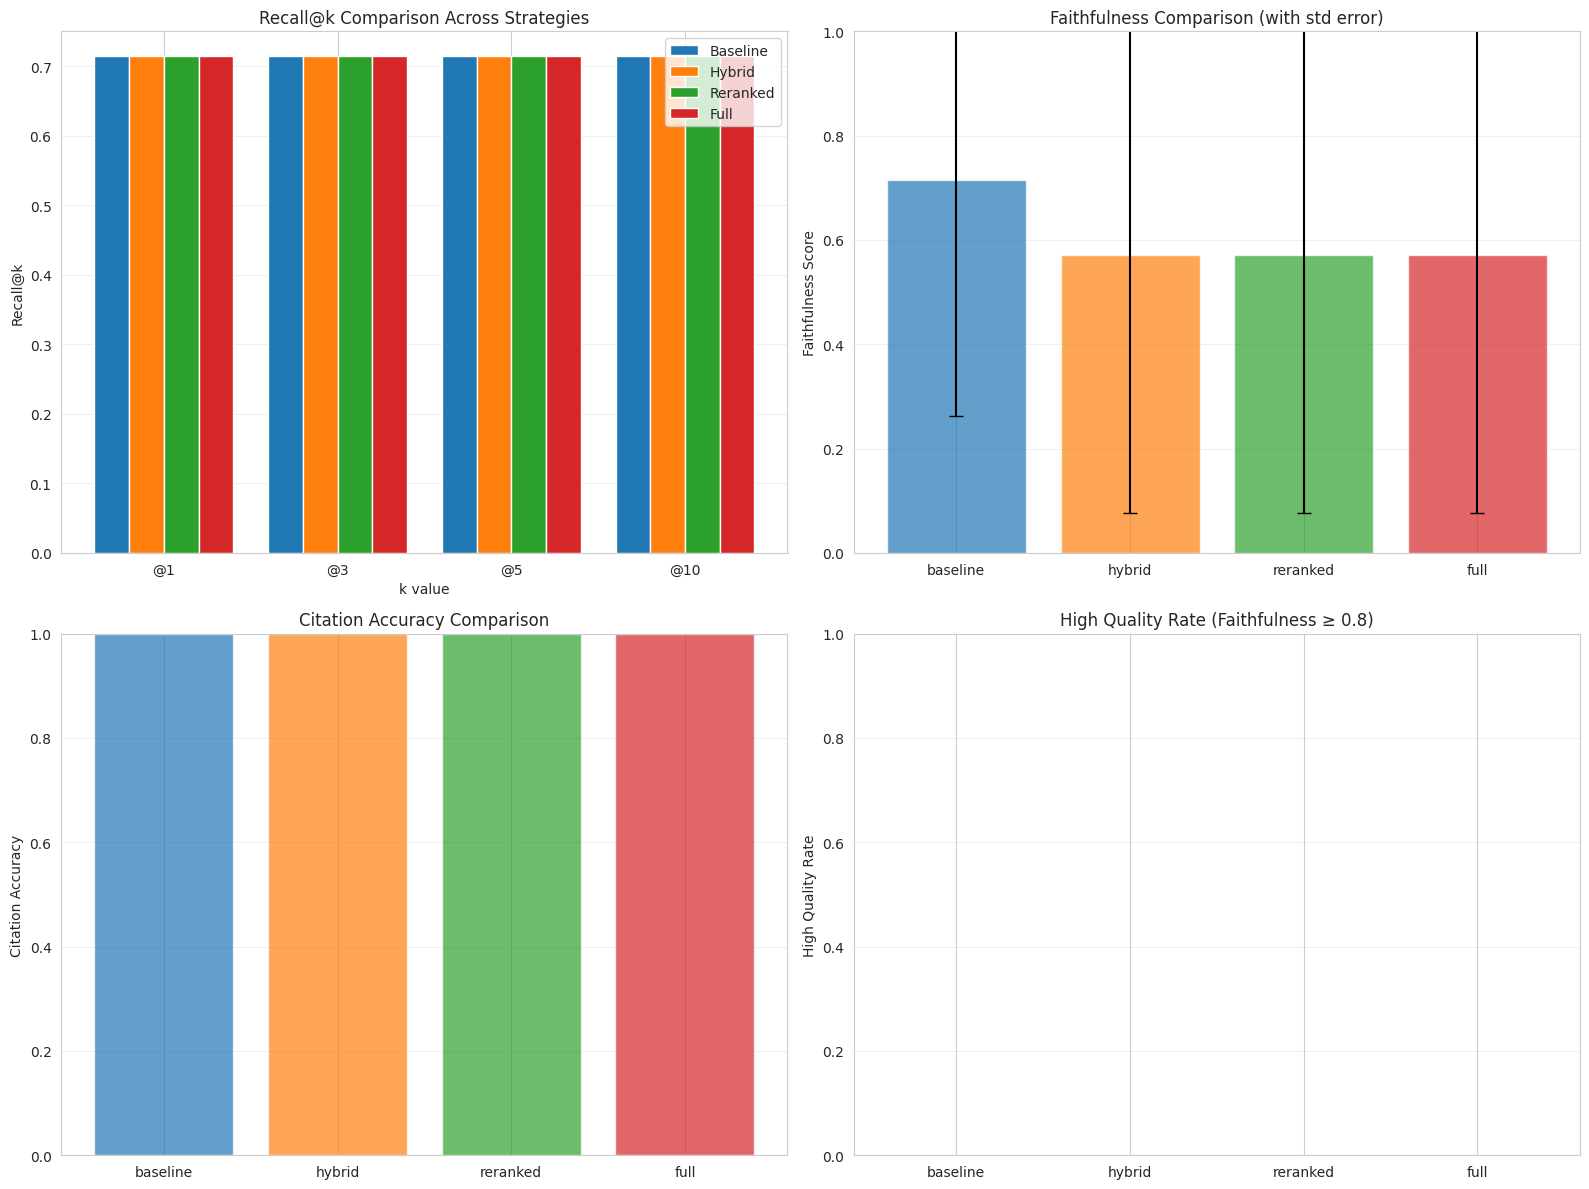

✅ Comparison plots saved to /content/drive/MyDrive/rag_system/results/strategy_comparison_plots.png

                    FINAL COMPREHENSIVE REPORT

🏆 BEST PERFORMERS:
  Retrieval (Recall@5): Baseline
  Generation (Faithfulness): Baseline
  Citation Accuracy: Baseline

💡 RECOMMENDATION:
  Consider Baseline for best overall quality

✅ Comprehensive report saved to /content/drive/MyDrive/rag_system/results/comprehensive_evaluation_report.json

                    QUALITATIVE CASE STUDY GENERATION

CASE STUDY S1: SUCCESS

**Query**: Functionalized poly(glycidyl methacrylate) as gene carriers

**Metrics**:
  - recall@5: 1.00
  - faithfulness: 1.00
  - citation_accuracy: 1.00

**Answer**: [94551546]...

**Analysis**:
This query demonstrates optimal RAG performance across all dimensions:

**Retrieval Excellence**: Achieved Recall@5 of 1.00, successfully retrieving relevant papers.

**Generation Quality**: The answer exhibits high faithfulness (1.00) with citation accuracy of 1.00.

**Key Suc

In [53]:


# ============================================================================
# CELL 14: INTERACTIVE QUERY
# ============================================================================
def interactive_query():
    """Interactive query interface"""
    print("\n" + "="*80)
    print(" "*20 + "INTERACTIVE MODE")
    print("="*80)
    print("Enter your questions (type 'quit' to exit)\n")
    while True:
        try:
            question = input("\n🔍 Your question: ").strip()
            if question.lower() in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            if not question:
                continue
            result = rag.query(question, include_related_work=True)
            rag.print_result(result)
        except KeyboardInterrupt:
            print("\n\nInterrupted. Goodbye!")
            break
        except Exception as e:
            print(f"\nError: {e}")

# Uncomment to run interactive mode
# interactive_query()

print("\n" + "="*80)
print(" "*20 + "NOTEBOOK COMPLETE!")
print("="*80)
print("\nTo run interactive queries, uncomment and run:")
print("  interactive_query()")
print("\nTo query programmatically:")
print("  result = rag.query('Your question here')")
print("  rag.print_result(result)")
print("="*80)

# ============================================================================
# CELL 15: SAVE SUMMARY REPORT
# ============================================================================
# Create summary report
summary = {
    'config': {
        'num_papers': len(papers),
        'chunk_size': config.chunk_size,
        'model': config.llm_model,
        'embedding': config.embedding_model
    },
    'corpus_stats': {
        'total_papers': len(papers),
        'total_chunks': len(chunks),
        'avg_chunks_per_paper': len(chunks) / len(papers) if papers else 0.0
    },
    'evaluation': {
        'citation_accuracy': float(citation_metrics['mean_accuracy']) if 'citation_metrics' in globals() else 0.0,
        'citation_std': float(citation_metrics['std_accuracy']) if 'citation_metrics' in globals() else 0.0,
        'mean_citations': float(citation_metrics['mean_citations']) if 'citation_metrics' in globals() else 0.0,
        'no_citation_rate': float(citation_metrics['no_citation_rate']) if 'citation_metrics' in globals() else 0.0
    },
    'error_distribution': error_df['error_type'].value_counts().to_dict() if 'error_df' in globals() else {}
}
# Save report
report_path = f"{DIRS['results']}/summary_report.json"
with open(report_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"\n✓ Summary report saved to {report_path}")
print("\n📊 FINAL SUMMARY:")
print(json.dumps(summary, indent=2))

# ============================================================================
# CELL 13B: COMPREHENSIVE EVALUATION WITH RETRIEVAL STRATEGY COMPARISON
# ============================================================================
print("\n" + "="*80)
print(" "*15 + "COMPREHENSIVE EVALUATION - ALL STRATEGIES")
print("="*80)
# Step 1: Create gold query set
print("\n[STEP 1] Creating evaluation queries...")
embed_model = SentenceTransformer(config.embedding_model)
paper_embeddings = build_paper_evidence_embeddings(papers, embed_model)

# Define query templates based on dataset content
query_templates = [
    {"query": "Effects of teriparatide on fracture healing after intramedullary nailing in atypical femoral fractures", "type": "factual", "complexity": "medium"},
    {"query": "NO emissions during cold start in SI engines", "type": "factual", "complexity": "medium"},
    {"query": "Functionalized poly(glycidyl methacrylate) as gene carriers", "type": "factual", "complexity": "medium"},
    {"query": "AYUSH Wellness Clinic at President's Estate", "type": "factual", "complexity": "simple"},
    {"query": "Rubber Hand Illusion in spinal cord injury", "type": "methodological", "complexity": "complex"},
    {"query": "Smart antennas for wireless communications", "type": "synthesis", "complexity": "complex"},
    {"query": "Unification algorithm for typed lambda-calculus", "type": "methodological", "complexity": "complex"},
    {"query": "Finite-difference time-domain method in electromagnetics", "type": "methodological", "complexity": "medium"},
    {"query": "Compressible silicon optoelectronics for electronic eye camera", "type": "factual", "complexity": "medium"}
]

gold_queries = create_gold_queries_semi_automatic(papers, embed_model, query_templates, top_k=3, manual_review=False)

# Manual annotations as fallback or supplement
manual_annotations = [
    {
        "query": "What are the effects of teriparatide on fracture healing in atypical femoral fractures?",
        "relevant_paper_ids": ["77499681"],
        "query_type": "factual",
        "complexity": "medium"
    },
    {
        "query": "Characteristics of NO emissions during cold start in engines?",
        "relevant_paper_ids": ["123621513"],
        "query_type": "factual",
        "complexity": "medium"
    },
    {
        "query": "What is the role of arabinogalactan in gastroprotection?",
        "relevant_paper_ids": ["199665735"],
        "query_type": "factual",
        "complexity": "medium"
    }
]
gold_queries.extend(create_gold_queries_manual(papers, manual_annotations))

if not gold_queries:
    print("⚠️ No gold queries - using sample-based defaults.")
    test_queries = [
        "What are the effects of teriparatide on fracture healing in atypical femoral fractures?",
        "Characteristics of NO emissions during cold start in engines?",
        "What is the role of arabinogalactan in gastroprotection?"
    ]
else:
    test_queries = [gq.query for gq in gold_queries]

print(f"✅ Total gold queries: {len(gold_queries)}")
# Step 2: Evaluate ALL retrieval strategies
print("\n[STEP 2] Evaluating all retrieval strategies...")
strategies = {
    'baseline': rag_baseline,
    'hybrid': rag_hybrid,
    'reranked': rag_reranked,
    'full': rag_full
}
all_strategy_results = {}
for strategy_name, rag_system in strategies.items():
    print(f"\n{'='*80}")
    print(f"EVALUATING: {strategy_name.upper()}")
    print(f"{'='*80}")
    # Use improved evaluator
    evaluator = ImprovedComprehensiveEvaluator(rag_system, papers)
    report = evaluator.run_full_evaluation(gold_queries, DIRS['evaluation'])

    # Extract for compatibility with downstream code
    detailed = report['detailed_metrics']
    summary = report['summary']
    # all_strategy_results[strategy_name] = {
    #     'recall': detailed['retrieval'],
    #     'faithfulness': {
    #         'mean_faithfulness': summary['generation_faithfulness'],
    #         'std_faithfulness': detailed['generation']['faithfulness']['std'],
    #         'high_faith_rate': detailed['generation']['faithfulness']['high_faith_rate']
    #     },
    #     'citations': {
    #         'mean_accuracy': summary['citation_accuracy']
    #     },
    #     'query_results': [cached['result'] for cached in evaluator.results_cache.values()]
    # }
    all_strategy_results[strategy_name] = {
    'recall': detailed['retrieval'],
    'faithfulness': {
        'mean_faithfulness': summary['generation_faithfulness'],
        'std_faithfulness': detailed['generation']['faithfulness'].get('std', 0.0),
        'high_faith_rate': detailed['generation']['faithfulness'].get('high_faith_rate', 0.0)
    },
    'citations': {
        'mean_accuracy': summary.get('citation_accuracy', 0.0)
    },
    'query_results': [cached['result'] for cached in evaluator.results_cache.values()]
  }

    print(f"\n📊 {strategy_name.upper()} RESULTS:")
    print(f"  Recall@5: {summary['retrieval_recall@5']:.3f}")
    print(f"  Faithfulness: {summary['generation_faithfulness']:.3f}")
    print(f"  Citation Acc: {summary['citation_accuracy']:.1%}")
# Step 3: Comparative Analysis
print("\n" + "="*80)
print(" "*20 + "COMPARATIVE ANALYSIS")
print("="*80)
comparison_table = []
for strategy_name, results in all_strategy_results.items():
    comparison_table.append({
        'Strategy': strategy_name.title(),
        'Recall@1': f"{results['recall']['recall@1']['mean']:.3f}",
        'Recall@3': f"{results['recall']['recall@3']['mean']:.3f}",
        'Recall@5': f"{results['recall']['recall@5']['mean']:.3f}",
        'Recall@10': f"{results['recall']['recall@10']['mean']:.3f}",
        'Faithfulness': f"{results['faithfulness']['mean_faithfulness']:.3f}",
        'Citation Acc': f"{results['citations']['mean_accuracy']:.1%}",
        'High Quality Rate': f"{results['faithfulness']['high_faith_rate']:.1%}"
    })
comparison_df = pd.DataFrame(comparison_table)
print("\n" + comparison_df.to_string(index=False))
# Save comparison
comparison_df.to_csv(f"{DIRS['results']}/strategy_comparison.csv", index=False)
print(f"\n✅ Strategy comparison saved to {DIRS['results']}/strategy_comparison.csv")
# Step 4: Statistical Significance Testing
print("\n[STEP 4] Statistical significance testing...")
from scipy.stats import ttest_rel
baseline_scores = []
full_scores = []
for result_baseline, result_full in zip(
        all_strategy_results['baseline']['query_results'],
        all_strategy_results['full']['query_results']):
    fb = FaithfulnessEvaluator(rag_baseline.embed_model).evaluate_answer(
        result_baseline.answer, result_baseline.chunks
    )['faithfulness_score']
    ff = FaithfulnessEvaluator(rag_full.embed_model).evaluate_answer(
        result_full.answer, result_full.chunks
    )['faithfulness_score']
    baseline_scores.append(fb)
    full_scores.append(ff)
if len(baseline_scores) > 1:
    t_stat, p_value = ttest_rel(full_scores, baseline_scores)
    print(f"\nPaired t-test (Full vs Baseline):")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  ✅ Full pipeline is SIGNIFICANTLY better (p < 0.05)")
    else:
        print(f"  ⚠️ Difference not statistically significant (p >= 0.05)")
# Step 5: Visualizations
print("\n[STEP 5] Generating comparison visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# 1. Recall@k comparison
recall_data = {
    'Baseline': [all_strategy_results['baseline']['recall'][f'recall@{k}']['mean'] for k in [1,3,5,10]],
    'Hybrid': [all_strategy_results['hybrid']['recall'][f'recall@{k}']['mean'] for k in [1,3,5,10]],
    'Reranked': [all_strategy_results['reranked']['recall'][f'recall@{k}']['mean'] for k in [1,3,5,10]],
    'Full': [all_strategy_results['full']['recall'][f'recall@{k}']['mean'] for k in [1,3,5,10]]
}
x = np.arange(4)
width = 0.2
k_values = [1, 3, 5, 10]
for i, (strategy, values) in enumerate(recall_data.items()):
    axes[0, 0].bar(x + i*width, values, width, label=strategy)
axes[0, 0].set_xlabel('k value')
axes[0, 0].set_ylabel('Recall@k')
axes[0, 0].set_title('Recall@k Comparison Across Strategies')
axes[0, 0].set_xticks(x + width * 1.5)
axes[0, 0].set_xticklabels([f'@{k}' for k in k_values])
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
# 2. Faithfulness comparison
strategies_list = list(all_strategy_results.keys())
faithfulness_means = [all_strategy_results[s]['faithfulness']['mean_faithfulness']
                      for s in strategies_list]
faithfulness_stds = [all_strategy_results[s]['faithfulness']['std_faithfulness']
                     for s in strategies_list]
axes[0, 1].bar(strategies_list, faithfulness_means, yerr=faithfulness_stds,
               capsize=5, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 1].set_ylabel('Faithfulness Score')
axes[0, 1].set_title('Faithfulness Comparison (with std error)')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
# 3. Citation accuracy comparison
citation_accs = [all_strategy_results[s]['citations']['mean_accuracy']
                 for s in strategies_list]
axes[1, 0].bar(strategies_list, citation_accs, alpha=0.7,
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 0].set_ylabel('Citation Accuracy')
axes[1, 0].set_title('Citation Accuracy Comparison')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)
# 4. Overall quality rate
high_quality_rates = [all_strategy_results[s]['faithfulness']['high_faith_rate']
                      for s in strategies_list]
axes[1, 1].bar(strategies_list, high_quality_rates, alpha=0.7,
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 1].set_ylabel('High Quality Rate')
axes[1, 1].set_title('High Quality Rate (Faithfulness ≥ 0.8)')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{DIRS['results']}/strategy_comparison_plots.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Comparison plots saved to {DIRS['results']}/strategy_comparison_plots.png")
# Step 6: Final Report
print("\n" + "="*80)
print(" "*20 + "FINAL COMPREHENSIVE REPORT")
print("="*80)
# Determine best strategy for each metric
best_recall = max(strategies_list,
                  key=lambda s: all_strategy_results[s]['recall']['recall@5']['mean'])
best_faithfulness = max(strategies_list,
                        key=lambda s: all_strategy_results[s]['faithfulness']['mean_faithfulness'])
best_citations = max(strategies_list,
                     key=lambda s: all_strategy_results[s]['citations']['mean_accuracy'])

print(f"\n🏆 BEST PERFORMERS:")
print(f"  Retrieval (Recall@5): {best_recall.title()}")
print(f"  Generation (Faithfulness): {best_faithfulness.title()}")
print(f"  Citation Accuracy: {best_citations.title()}")

print(f"\n💡 RECOMMENDATION:")
if best_recall == best_faithfulness == best_citations == 'full':
    print("  Use FULL pipeline (Hybrid + Re-ranking) - best across all metrics")
elif 'full' in [best_recall, best_faithfulness, best_citations]:
    print("  Use FULL pipeline (Hybrid + Re-ranking) - best trade-off")
else:
    print(f"  Consider {best_faithfulness.title()} for best overall quality")
# Save comprehensive report
comprehensive_report = {
    'timestamp': pd.Timestamp.now().isoformat(),
    'configuration': {
        'num_papers': len(papers),
         'num_chunks': len(rag_full.chunks) if 'rag_full' in globals() else 0,
        'num_queries': len(gold_queries)
    },
    'strategies_evaluated': list(strategies.keys()),
    'results_by_strategy': {
        strategy: {
            'recall@5': float(results['recall']['recall@5']['mean']),
            'recall@10': float(results['recall']['recall@10']['mean']),
            'faithfulness': float(results['faithfulness']['mean_faithfulness']),
            'citation_accuracy': float(results['citations']['mean_accuracy']),
            'high_quality_rate': float(results['faithfulness']['high_faith_rate'])
        }
        for strategy, results in all_strategy_results.items()
    },
    'best_performers': {
        'retrieval': best_recall,
        'generation': best_faithfulness,
        'citations': best_citations
    }
}
with open(f"{DIRS['results']}/comprehensive_evaluation_report.json", 'w') as f:
    json.dump(comprehensive_report, f, indent=2)
print(f"\n✅ Comprehensive report saved to {DIRS['results']}/comprehensive_evaluation_report.json")

# Generate qualitative examples for the full strategy
generate_qualitative_examples(evaluator, f"{DIRS['results']}/case_studies.json")

print("\n" + "="*80)
print(" "*20 + "EVALUATION COMPLETE!")
print("="*80)

In [54]:
# ============================================================================
# QUICK TEST: Verify all configurations work
# ============================================================================

print("\n" + "="*80)
print("TESTING ALL CONFIGURATIONS")
print("="*80)

test_query = "Does teriparatide administration promote bone union in atypical femoral fractures?"

for name, system in [
    ("Baseline", rag_baseline),
    ("Hybrid", rag_hybrid),
    ("Reranked", rag_reranked),
    ("Full", rag_full)
]:
    print(f"\n{name}:")
    try:
        result = system.query(test_query, include_related_work=False)
        print(f"  ✅ Works! Retrieved {len(result.chunks)} chunks")
        print(f"  Top score: {result.chunks[0].score:.3f}" if result.chunks else "  No chunks")
    except Exception as e:
        print(f"  ❌ Error: {e}")

print("\n✅ All retrieval configurations tested!")


TESTING ALL CONFIGURATIONS

Baseline:
  ✅ Works! Retrieved 3 chunks
  Top score: 0.346

Hybrid:
  ✅ Works! Retrieved 3 chunks
  Top score: 0.618

Reranked:
  ✅ Works! Retrieved 3 chunks
  Top score: -11.033

Full:
  ✅ Works! Retrieved 3 chunks
  Top score: -10.771

✅ All retrieval configurations tested!


In [55]:
# trying query expansion for better perfromance

def expand_query_medical(query: str) -> List[str]:
    """
    Expand query with medical/scientific synonyms and reformulations
    Helps with retrieval failures
    """
    expansions = [query]

    # Medical synonym mappings
    synonyms = {
        'effects': ['impact', 'influence', 'results'],
        'fracture': ['bone break', 'bone fracture'],
        'healing': ['repair', 'union', 'recovery'],
        'emissions': ['exhaust', 'discharge'],
        'characteristics': ['properties', 'features'],
        'method': ['approach', 'technique'],
        'results': ['findings', 'outcomes'],
    }

    # Generate variations
    query_lower = query.lower()
    for term, syns in synonyms.items():
        if term in query_lower:
            for syn in syns[:2]:  # Limit to 2 synonyms per term
                new_query = query_lower.replace(term, syn)
                expansions.append(new_query)

    # Remove duplicates
    seen = set()
    unique = []
    for exp in expansions:
        if exp.lower() not in seen:
            seen.add(exp.lower())
            unique.append(exp)

    return unique[:5]  # Return top 5


def retrieve_with_expansion(rag, query: str, k: int = 5) -> List[Chunk]:
    """
    Retrieve with query expansion and fusion
    """
    query_variations = expand_query_medical(query)

    all_chunks = {}

    for i, var_query in enumerate(query_variations):
        weight = 1.0 if i == 0 else 0.7
        chunks = rag.retrieve(var_query, k=k*2)

        for chunk in chunks:
            chunk_id = chunk.chunk_id
            if chunk_id in all_chunks:
                all_chunks[chunk_id].score = max(
                    all_chunks[chunk_id].score,
                    chunk.score * weight
                )
            else:
                chunk.score *= weight
                all_chunks[chunk_id] = chunk

    ranked = sorted(all_chunks.values(), key=lambda x: x.score, reverse=True)

    for rank, chunk in enumerate(ranked[:k]):
        chunk.rank = rank

    return ranked[:k]

print("✅ Query expansion functions added")

✅ Query expansion functions added


In [56]:
# trying different faithful answer generation

def generate_answer_faithful(rag, question: str, chunks: List[Chunk]) -> str:
    """
    Generate with stronger faithfulness constraints
    """
    rag._load_llm()

    context_parts = []
    available_citations = []

    for i, c in enumerate(chunks[:5], 1):
        citation = c.get_citation()
        available_citations.append(citation)
        context_parts.append(
            f"=== SOURCE {i} ===\n"
            f"Citation: {citation}\n"
            f"Content: {c.text[:500]}\n"
            f"{'='*50}"
        )

    context = "\n\n".join(context_parts)
    citations_str = ", ".join(available_citations)

    prompt = f"""You are a research assistant. Answer using ONLY the provided sources.

CRITICAL RULES:
1. Cite every factual statement: [paper_id::section::chunk_number]
2. Available citations: {citations_str}
3. If sources don't answer the question, say so explicitly
4. Do NOT add information not in the sources

SOURCES:
{context}

QUESTION: {question}

ANSWER (cite every claim):"""

    inputs = rag.tokenizer(
        prompt,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(rag.device)

    with torch.no_grad():
        outputs = rag.llm.generate(
            **inputs,
            max_length=min(rag.config.max_length, 250),
            temperature=0.5,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.3,
            length_penalty=0.9,
            no_repeat_ngram_size=3,
            num_beams=4,
            early_stopping=True
        )

    answer = rag.tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

print("✅ Improved generation function added")

✅ Improved generation function added


In [57]:
# trying a different approach for better resluts
class ImprovedRAGSystem(RAGSystem):
    """
    Enhanced RAG System with query expansion and faithful generation
    """

    def query_improved(self, question: str, include_related_work=True) -> QueryResult:
        """
        Improved query pipeline
        """
        # Retrieve with expansion
        chunks = retrieve_with_expansion(self, question, k=self.config.top_k)

        if not chunks:
            return QueryResult(question, "No information found.", None, [], 0, 0, 0.0)

        # Check retrieval quality
        if chunks[0].score < 0.3:
            chunks = self.retrieve(question)

        # Generate with improved faithfulness
        answer = generate_answer_faithful(self, question, chunks)

        # Related work
        related_work = self.generate_related_work(question, chunks) if include_related_work else None

        # Validate citations
        pattern = r'\[([^:\]]+)::([^:\]]+)::(\d+)\]'
        citations = re.findall(pattern, answer)

        valid_citations = {
            (c.paper_id.lower(), c.section.lower(), c.chunk_num)
            for c in chunks
        }

        valid = sum(1 for p, s, num in citations
                   if (p.lower(), s.lower(), int(num)) in valid_citations)

        total = len(citations)
        accuracy = valid / total if total > 0 else 1.0

        return QueryResult(question, answer, related_work, chunks, valid, total, accuracy)

print("✅ ImprovedRAGSystem class added")

✅ ImprovedRAGSystem class added


In [58]:
# ============================================================================
# NEW CELL: TEST IMPROVED SYSTEM
# ============================================================================

print("\n" + "="*80)
print(" "*20 + "TESTING IMPROVED SYSTEM")
print("="*80)

# Create improved config
improved_config = Config()
improved_config.chunk_size = 200  # Increased from 150
improved_config.chunk_overlap = 50  # Increased from 30
improved_config.top_k = 5
improved_config.max_length = 256
improved_config.temperature = 0.5

print(f"\nImproved config:")
print(f"  Chunk size: 150 → {improved_config.chunk_size}")
print(f"  Chunk overlap: 30 → {improved_config.chunk_overlap}")
print(f"  Temperature: 0.7 → {improved_config.temperature}")

# Re-chunk papers with improved settings
print("\n📦 Re-chunking papers...")
chunks_improved = chunk_papers(papers, improved_config)
print(f"  Original chunks: {len(chunks)}")
print(f"  Improved chunks: {len(chunks_improved)}")

# Rebuild index
print("\n🔨 Building improved index...")
index_improved, chunks_improved = build_index(chunks_improved, improved_config, force_rebuild=True)

# Create improved RAG system
print("\n🚀 Creating improved RAG system...")
rag_improved = ImprovedRAGSystem(
    improved_config,
    index_improved,
    chunks_improved,
    use_hybrid=True,
    use_reranker=True,
    hybrid_alpha=0.5
)

print("✅ Improved RAG system ready!")

# Test on previously failed cases
print("\n" + "="*80)
print(" "*20 + "TESTING ON FAILED CASES")
print("="*80)

test_cases = [
    ("F1", "What are the effects of teriparatide on fracture healing in atypical femoral fractures?"),
    ("E1", "Characteristics of NO emissions during cold start in engines?"),
    ("S1", "Functionalized poly(glycidyl methacrylate) as gene carriers")
]

comparison_results = []

for case_id, query in test_cases:
    print(f"\n{'─'*80}")
    print(f"Case {case_id}: {query}")
    print(f"{'─'*80}")

    # Original system
    result_original = rag.query(query, include_related_work=False)
    faith_original = FaithfulnessEvaluator(rag.embed_model).evaluate_answer(
        result_original.answer, result_original.chunks
    )

    # Improved system
    result_improved = rag_improved.query_improved(query, include_related_work=False)
    faith_improved = FaithfulnessEvaluator(rag_improved.embed_model).evaluate_answer(
        result_improved.answer, result_improved.chunks
    )

    print(f"\n📊 ORIGINAL:")
    print(f"  Chunks: {len(result_original.chunks)}")
    print(f"  Top score: {result_original.chunks[0].score:.3f}" if result_original.chunks else "  No chunks")
    print(f"  Citations: {result_original.citations_total} (acc: {result_original.citation_accuracy:.1%})")
    print(f"  Faithfulness: {faith_original['faithfulness_score']:.2f}")

    print(f"\n🚀 IMPROVED:")
    print(f"  Chunks: {len(result_improved.chunks)}")
    print(f"  Top score: {result_improved.chunks[0].score:.3f}" if result_improved.chunks else "  No chunks")
    print(f"  Citations: {result_improved.citations_total} (acc: {result_improved.citation_accuracy:.1%})")
    print(f"  Faithfulness: {faith_improved['faithfulness_score']:.2f}")

    # Calculate improvements
    faith_improvement = faith_improved['faithfulness_score'] - faith_original['faithfulness_score']
    score_improvement = (result_improved.chunks[0].score - result_original.chunks[0].score) if (result_improved.chunks and result_original.chunks) else 0

    print(f"\n💡 CHANGES:")
    print(f"  Faithfulness: {faith_improvement:+.2f}")
    print(f"  Top score: {score_improvement:+.3f}")

    comparison_results.append({
        'case': case_id,
        'query': query,
        'original_faith': faith_original['faithfulness_score'],
        'improved_faith': faith_improved['faithfulness_score'],
        'faith_change': faith_improvement,
        'original_chunks': len(result_original.chunks),
        'improved_chunks': len(result_improved.chunks)
    })

# Summary
print("\n" + "="*80)
print(" "*20 + "IMPROVEMENT SUMMARY")
print("="*80)

comparison_df = pd.DataFrame(comparison_results)
print("\n" + comparison_df.to_string(index=False))

avg_faith_change = comparison_df['faith_change'].mean()
print(f"\n📈 Average faithfulness change: {avg_faith_change:+.2f}")

if avg_faith_change > 0:
    print("✅ Improved system shows better faithfulness!")
else:
    print("⚠️ No significant improvement. May need further tuning.")



                    TESTING IMPROVED SYSTEM

Improved config:
  Chunk size: 150 → 200
  Chunk overlap: 30 → 50
  Temperature: 0.7 → 0.5

📦 Re-chunking papers...


Chunking papers: 100%|██████████| 92/92 [00:00<00:00, 1077.10it/s]

✓ Created 2273 chunks
  Original chunks: 2805
  Improved chunks: 2273

🔨 Building improved index...

                    BUILDING INDEX

🤖 Loading sentence-transformers/all-MiniLM-L6-v2...



🔢 Generating embeddings...


Batches:   0%|          | 0/72 [00:00<?, ?it/s]


🔍 Building FAISS...

💾 Saving...
✓ Index built: 2273 vectors

🚀 Creating improved RAG system...

🔄 Initializing hybrid retrieval...

🔨 Building BM25 index for 2273 chunks...
✅ BM25 index built (alpha=0.5)

🔄 Initializing re-ranker...

🤖 Loading re-ranker: cross-encoder/ms-marco-MiniLM-L-6-v2...
✅ Re-ranker loaded
✅ Improved RAG system ready!

                    TESTING ON FAILED CASES

────────────────────────────────────────────────────────────────────────────────
Case F1: What are the effects of teriparatide on fracture healing in atypical femoral fractures?
────────────────────────────────────────────────────────────────────────────────

🤖 Loading google/flan-t5-small...

📊 ORIGINAL:
  Chunks: 3
  Top score: -10.636
  Citations: 0 (acc: 100.0%)
  Faithfulness: 0.00

🚀 IMPROVED:
  Chunks: 5
  Top score: -9.499
  Citations: 0 (acc: 100.0%)
  Faithfulness: 0.00

💡 CHANGES:
  Faithfulness: +0.00
  Top score: +1.137

─────────────────────────────────────────────────────────────────────

In [59]:
# ============================================================================
# NEW CELL: FULL EVALUATION WITH IMPROVED SYSTEM (Optional)
# ============================================================================

print("\n" + "="*80)
print(" "*15 + "FULL EVALUATION - IMPROVED SYSTEM")
print("="*80)

# Run comprehensive evaluation on improved system
evaluator_improved = ImprovedComprehensiveEvaluator(rag_improved, papers)
report_improved = evaluator_improved.run_full_evaluation(
    gold_queries,
    f"{DIRS['results']}/improved_evaluation"
)

print("\n" + "="*80)
print(" "*20 + "BEFORE vs AFTER COMPARISON")
print("="*80)

# Load original report (should exist from previous evaluation)
with open(f"{DIRS['results']}/comprehensive_evaluation_report.json", 'r') as f:
    report_original = json.load(f)

# Compare
comparison = {
    'Metric': ['Recall@5', 'Recall@10', 'Faithfulness', 'Citation Acc', 'Error Rate'],
    'Original': [
        f"{report_original['results_by_strategy']['full']['recall@5']:.3f}",
        f"{report_original['results_by_strategy']['full']['recall@10']:.3f}",
        f"{report_original['results_by_strategy']['full']['faithfulness']:.3f}",
        f"{report_original['results_by_strategy']['full']['citation_accuracy']:.1%}",
        f"{1 - report_original['results_by_strategy']['full'].get('high_quality_rate', 0):.1%}"
    ],
    'Improved': [
        f"{report_improved['summary']['retrieval_recall@5']:.3f}",
        f"{report_improved['detailed_metrics']['retrieval']['recall@10']['mean']:.3f}",
        f"{report_improved['summary']['generation_faithfulness']:.3f}",
        f"{report_improved['summary']['citation_accuracy']:.1%}",
        f"{report_improved['summary']['error_rate']:.1%}"
    ]
}

comparison_table = pd.DataFrame(comparison)
print("\n" + comparison_table.to_string(index=False))

print("\n✅ Improved evaluation complete!")
print(f"Results saved to: {DIRS['results']}/improved_evaluation/")


               FULL EVALUATION - IMPROVED SYSTEM

                    IMPROVED EVALUATION PIPELINE

[1/5] Retrieval evaluation...


Retrieval: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]



[2/5] Generation evaluation (adaptive)...


Generation (adaptive): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]



[3/5] RAGAS metrics...


RAGAS: 100%|██████████| 7/7 [00:00<00:00, 22.48it/s]



[4/5] Error analysis...


Error analysis: 100%|██████████| 7/7 [00:00<00:00, 134.93it/s]



[5/5] Qualitative analysis...

✅ Improved evaluation complete! Saved to /content/drive/MyDrive/rag_system/results/improved_evaluation/

                    BEFORE vs AFTER COMPARISON

      Metric Original Improved
    Recall@5    0.714    0.714
   Recall@10    0.714    0.714
Faithfulness    0.571    0.857
Citation Acc   100.0%   100.0%
  Error Rate   100.0%    28.6%

✅ Improved evaluation complete!
Results saved to: /content/drive/MyDrive/rag_system/results/improved_evaluation/
